In [1]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from fitter import Fitter
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 1.1. Выделение итогового набора полей для одной записи

In [2]:
# Получение иноформации "как есть" для RecordID 132539
df_ = pd.read_table('set/132539.txt', delimiter = ',') 
print(df_)
out = pd.read_table('outcomes.txt', delimiter = ',')
print(out[['RecordID', 'Survival', 'In-hospital_death']].iloc[0])

      Time Parameter      Value
0    00:00  RecordID  132539.00
1    00:00       Age      54.00
2    00:00    Gender       0.00
3    00:00    Height      -1.00
4    00:00   ICUType       4.00
..     ...       ...        ...
268  47:37     NIMAP      79.33
269  47:37  NISysABP     128.00
270  47:37  RespRate      23.00
271  47:37      Temp      37.80
272  47:37     Urine     280.00

[273 rows x 3 columns]
RecordID             132539
Survival                 -1
In-hospital_death         0
Name: 0, dtype: int64


Все поля представляют собой отдельные значения, разбиение полей с множеством значений на несоклько полей не требуется.

# 1.2 Создание структуры данных для итогового набора полей

Анализ встречаемости параметров: определение, какие параметры встречаются редко (меньше 1 данных на запись в среднем), встречаются ровно один раз в записи, встречаются больше одного раза в записи (для них высчитываем потом среднее значение), встречаются значительно больше одного раза в записи (для них высчитываем потом квартили 0,25, 0,5, 0,75).

In [3]:
# Получаем все значения RecordID из столбца outcomes.txt
out = pd.read_table('outcomes.txt', delimiter = ',')
RIDs = out["RecordID"]
n = len(RIDs)
# Формируем Counter, в котором все параметры будут считаться
x = Counter()
for rid in RIDs:
    df_ = pd.read_table('set/' + str(rid) + '.txt', delimiter = ',') 
    x = x + Counter(df_["Parameter"])

# Разделение параметров по встречаемости
unique_parameters = list(x.keys())
one_params = []
mean_params = []
rare_params = []
quantile_params = []
for parameter in unique_parameters:
    if x[parameter] / n > 10:
        quantile_params.append(parameter)
    elif x[parameter] / n > 1:
        mean_params.append(parameter)
    elif x[parameter] / n < 1:
        rare_params.append(parameter)
    else:
        one_params.append(parameter)

feature_list = one_params + rare_params + mean_params + [s + "_25" for s in quantile_params] + quantile_params + [s + "_75" for s in quantile_params]

Наполнение структуры данных согласно указанныму выше алгоритму и сохранение датасета

In [4]:
df = pd.DataFrame(columns = feature_list, index = range(n))
for i, rid in enumerate(RIDs):
    df_ = pd.read_table('set/' + str(rid) + '.txt', delimiter = ',')
    df_edited = pd.DataFrame(0, index = range(1), columns = feature_list)
    for parameter in one_params:
        df_edited[parameter] = df_['Value'].where(df_["Parameter"] == parameter).sum()
    for parameter in rare_params:
        df_edited[parameter] = df_['Value'].where(df_["Parameter"] == parameter).mean()
    for parameter in mean_params:
        df_edited[parameter] = (df_['Value'].where(df_["Parameter"] == parameter)).mean()
    for parameter in quantile_params:
        df_edited[parameter + "_25"] = (df_['Value'].where(df_["Parameter"] == parameter)).quantile(0.25)
        df_edited[parameter] = (df_['Value'].where(df_["Parameter"] == parameter)).quantile(0.50)
        df_edited[parameter + "_75"] = (df_['Value'].where(df_["Parameter"] == parameter)).quantile(0.75)
    df.loc[i, feature_list] = df_edited.iloc[0].values

In [5]:
out = pd.read_table('outcomes.txt', delimiter = ',')
df["Survival"] = out["Survival"]
df["In-hospital_death"] = out["In-hospital_death"]
df.to_csv('dataset.csv', index=False)

# 1.3. Описание полученной структуры данных

In [6]:
df = pd.read_csv('dataset.csv')
df.describe(include='all')

,RecordID,Age,Gender,Height,ICUType,Albumin,ALP,ALT,AST,Bilirubin,Cholesterol,TroponinI,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,Weight_25,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,Weight_75,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,3246.000000,3379.000000,3456.000000,3461.000000,3446.000000,648.000000,386.000000,1805.000000,7876.000000,7880.000000,7880.000000,7799.000000,7863.000000,7814.000000,7870.000000,7831.000000,7862.000000,7861.000000,6071.000000,6035.000000,6034.000000,5419.000000,5040.0,3545.000000,4398.000000,8000.000000,7871.000000,7872.000000,7001.000000,6997.000000,7027.000000,2228.000000,7871.000000,7787.000000,5610.000000,5598.000000,5610.000000,8000.000000,7871.000000,7872.000000,7001.000000,6997.000000,7027.000000,2228.000000,7871.000000,7787.000000,5610.000000,5598.000000,5610.000000,8000.000000,7871.000000,7872.000000,7001.000000,6997.000000,7027.000000,2228.000000,7871.000000,7787.000000,5610.000000,5598.000000,5610.000000,8000.000000,8000.000000
mean,142672.608375,64.429750,0.561375,88.118225,2.783750,2.951625,105.159711,161.229856,228.553798,1.885847,155.957562,7.584448,1.017012,31.419125,25.497301,1.348567,137.410806,23.667621,2.014220,204.157717,4.130797,138.932744,12.797013,7.452670,40.347935,147.385179,0.551365,1.0,96.558512,2.352909,76.347884,10.858436,80.158886,51.820276,70.674160,109.356475,17.210278,36.652820,67.383106,54.179813,73.510004,108.642914,76.693694,12.023123,86.393102,56.892730,76.110781,117.451864,19.445916,37.048126,101.553808,59.104100,80.013755,119.008467,77.014403,12.755018,93.319582,62.505963,81.907831,125.782845,21.808797,37.387489,159.422444,64.496257,87.217435,129.512968,130.426875,0.140250
std,5857.052574,17.352628,0.498261,86.204173,1.013096,0.633583,105.184140,584.978187,821.954211,4.275192,44.158990,10.294487,2.557133,4.539272,20.484354,1.364306,39.902652,4.099630,0.315978,103.979725,0.482134,4.110270,21.442040,2.428755,7.849162,56.819635,0.132687,0.0,3.372498,1.681688,32.534383,4.003430,14.530749,11.708386,12.143607,19.903153,3.672339,0.726657,79.959196,10.495783,13.131870,19.782672,32.634815,3.597998,15.170093,12.183727,12.614420,20.626966,4.015055,0.601360,109.165001,10.794472,13.666671,20.447618,32.719336,3.229137,16.212965,12.939569,13.445586,21.798809,4.390170,0.630651,138.331617,11.582377,15.191067,21.883530,364.766144,0.347268
min,132539.000000,15.000000,-1.000000,-1.000000,1.000000,1.100000,12.000000,3.000000,6.000000,0.000000,28.000000,0.300000,0.010000,10.000000,1.285714,0.100000,49.000000,8.500000,1.066667,12.166667,2.500000,110.800000,0.075000,0.400000,12.400000,24.000000,0.210000,1.0,38.800000,0.400000,-1.000000,3.000000,23.000000,0.000000,0.000000,0.000000,8.000000,1.300000,0.000000,0.000000,1.000000,0.000000,-1.000000,3.000000,33.500000,0.000000,0.000000,0.000000,9.500000,31.800000,0.000000,0.000000,1.000000,0.000000,-1.000000,3.000000,36.000000,0.000000,0.000000,0.000000,12.000000,33.600000,0.000000,0.000000,1.000000,0.000000,-23.000000,0.000000
25%,137592.750000,53.000000,0.000000,-1.000000,2.000000,2.500000,57.500000,18.000000,25.000000,0.400000,124.000000,0.800000,0.040000,28.250000,13.000000,0.700000,112.000000,21.333333,1.833333,136.000000,3.800000,136.500000,8.750000,7.351847,36.000000,105.384615,0.460000,1.0,96.000000,1.335000,63.000000,8.000000,70.000000,44.000000,62.002500,96.500000,15.000000,36.250000,30.000000,48.000000,66.000000,97.000000,63.400000,10.000000,76.000000,48.500000,67.000000,103.500000,17.000000,36.700000,47.500000,53.000000,72.000000,106.000000,63.637500,10.000000,82.000000,53.500000,72.497500,111.000000,19.000000,36.950000,80.000000,57.750000,78.000000,115.750000,-1.000000,0.00

In [7]:
# Для полей из rare-params и mean-params рассчитывается среднее значение из имеющихся по человеку 
print("rare_params: ", rare_params)
print("mean_params: ", mean_params)
# Для полей из one-params Выдаётся единственное имеющееся значение
print("one_params: ", one_params)
# Для полей из quantile_params высчитывается 0,25, 0,50 и 0,75 квантили (обозначаются добавлением _25 и _75 к названию параметра)
print("quantile_params: ", quantile_params)

rare_params:  ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'Cholesterol', 'TroponinI', 'TroponinT']
mean_params:  ['HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2', 'FiO2', 'MechVent', 'SaO2', 'Lactate']
one_params:  ['RecordID', 'Age', 'Gender', 'Height', 'ICUType']
quantile_params:  ['Weight', 'GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'RespRate', 'Temp', 'Urine', 'DiasABP', 'MAP', 'SysABP']


In [8]:
# Название полей
df.columns

Index(['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Albumin', 'ALP',
       'ALT', 'AST', 'Bilirubin', 'Cholesterol', 'TroponinI', 'TroponinT',
       'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K',
       'Na', 'WBC', 'pH', 'PaCO2', 'PaO2', 'FiO2', 'MechVent', 'SaO2',
       'Lactate', 'Weight_25', 'GCS_25', 'HR_25', 'NIDiasABP_25', 'NIMAP_25',
       'NISysABP_25', 'RespRate_25', 'Temp_25', 'Urine_25', 'DiasABP_25',
       'MAP_25', 'SysABP_25', 'Weight', 'GCS', 'HR', 'NIDiasABP', 'NIMAP',
       'NISysABP', 'RespRate', 'Temp', 'Urine', 'DiasABP', 'MAP', 'SysABP',
       'Weight_75', 'GCS_75', 'HR_75', 'NIDiasABP_75', 'NIMAP_75',
       'NISysABP_75', 'RespRate_75', 'Temp_75', 'Urine_75', 'DiasABP_75',
       'MAP_75', 'SysABP_75', 'Survival', 'In-hospital_death'],
      dtype='object')

In [9]:
# типы полей
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RecordID           8000 non-null   float64
 1   Age                8000 non-null   float64
 2   Gender             8000 non-null   float64
 3   Height             8000 non-null   float64
 4   ICUType            8000 non-null   float64
 5   Albumin            3246 non-null   float64
 6   ALP                3379 non-null   float64
 7   ALT                3456 non-null   float64
 8   AST                3461 non-null   float64
 9   Bilirubin          3446 non-null   float64
 10  Cholesterol        648 non-null    float64
 11  TroponinI          386 non-null    float64
 12  TroponinT          1805 non-null   float64
 13  HCT                7876 non-null   float64
 14  BUN                7880 non-null   float64
 15  Creatinine         7880 non-null   float64
 16  Glucose            7799 

# 2.1. Устранение дубликатов, пустых записей

In [10]:
df = pd.read_csv('dataset.csv')

Категориальная обработка.
Удаляем столбцы Weight_25 и Weight_75 - они одинаковые с Weight, так как вес не сильно меняется в течение измерений.

In [11]:
df["Gender"] = df["Gender"].replace(-1, np.NaN)
df["Gender"] = df["Gender"] > 0
df["ICUType_1"] = df["ICUType"] == 1
df["ICUType_2"] = df["ICUType"] == 2
df["ICUType_3"] = df["ICUType"] == 3
df["ICUType_4"] = df["ICUType"] == 4
df = df.drop(columns = ["ICUType"])
df["MechVent"] = df["MechVent"] > 0

df = df.drop(columns=["Weight_75", "Weight_25"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 69 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RecordID           8000 non-null   float64
 1   Age                8000 non-null   float64
 2   Gender             8000 non-null   bool   
 3   Height             8000 non-null   float64
 4   Albumin            3246 non-null   float64
 5   ALP                3379 non-null   float64
 6   ALT                3456 non-null   float64
 7   AST                3461 non-null   float64
 8   Bilirubin          3446 non-null   float64
 9   Cholesterol        648 non-null    float64
 10  TroponinI          386 non-null    float64
 11  TroponinT          1805 non-null   float64
 12  HCT                7876 non-null   float64
 13  BUN                7880 non-null   float64
 14  Creatinine         7880 non-null   float64
 15  Glucose            7799 non-null   float64
 16  HCO3               7863 

Дубликаты отсутствуют, так как каждый файл с пациентом имеет своё уникальное имя, соответствующее RecordID

In [12]:
print(df.duplicated().any())

False


Проведём проверку на наличие пустых записей в таблице: записей, в которых совсем нет значений

In [13]:
df.dropna(how='all')

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,Cholesterol,TroponinI,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.00,43.25,63.7475,104.00,15.0,37.150,72.50,NaN,NaN,NaN,-1.0,15.0,73.0,49.0,70.000,110.0,18.0,37.70,100.0,NaN,NaN,NaN,15.0,77.00,55.75,77.170,121.50,20.00,37.900,217.50,NaN,NaN,NaN,-1,0,False,False,False,True
1,132540.0,76.0,True,175.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,NaN,13.50,80.00,51.00,70.3300,104.00,NaN,36.700,50.00,55.00,71.00,104.50,80.6,15.0,80.0,59.0,78.165,115.0,NaN,37.45,90.0,59.0,79.0,116.5,15.0,88.00,65.00,85.250,125.50,NaN,37.600,220.00,62.00,82.00,125.00,-1,0,False,True,False,False
2,132541.0,44.0,False,-1.0,2.5,116.0,83.0,199.5,2.9,NaN,NaN,NaN,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,5.00,75.50,73.25,91.6700,127.00,NaN,37.250,50.00,62.25,85.25,120.50,56.7,5.0,85.5,79.0,97.670,134.0,NaN,37.85,100.0,67.0,90.0,125.0,7.0,91.00,84.00,103.000,139.75,NaN,38.175,170.00,73.50,97.75,135.25,-1,0,False,False,True,False
3,132543.0,68.0,True,180.3,4.4,105.0,12.0,15.0,0.2,NaN,NaN,NaN,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.75,61.25,80.4150,116.00,13.5,36.100,562.50,NaN,NaN,NaN,84.6,15.0,74.0,64.0,83.670,120.0,16.0,36.40,625.0,NaN,NaN,NaN,15.0,76.00,69.00,86.670,128.00,18.00,36.400,668.75,NaN,NaN,NaN,575,0,False,False,True,False
4,132545.0,88.0,False,-1.0,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,68.75,38.00,70.0000,126.00,17.0,36.650,40.00,NaN,NaN,NaN,-1.0,15.0,73.0,42.0,75.330,131.0,19.0,37.00,50.0,NaN,NaN,NaN,15.0,81.25,54.00,80.000,142.00,21.00,37.150,63.75,NaN,NaN,NaN,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,152849.0,78.0,True,180.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,10.00,98.00,52.00,79.1650,133.50,NaN,36.625,40.00,58.00,75.50,111.00,88.7,15.0,103.0,56.0,83.330,143.0,NaN,36.85,80.0,62.0,83.0,130.0,15.0,105.50,62.50,90.500,148.00,NaN,37.100,140.00,66.00,92.00,147.50,752,0,False,True,False,False
7996,152851.0,90.0,True,177.8,NaN,74.0,12.0,25.0,1.0,NaN,NaN,0.142,29.762500,54.571429,2.157143,141.714286,15.428571,1.983333,278.428571,3.542857,139.857143,28.071429,7.276667,31.666667,77.333333,NaN,True,94.333333,3.961538,3.00,79.00,34.25,54.5825,93.75,NaN,36.600,10.00,41.75,64.00,107.75,87.0,7.5,82.0,38.0,63.835,108.5,NaN,37.15,20.0,46.5,71.0,120.5,8.5,91.00,45.75,69.500,125.00,NaN,37.675,26.00,49.00,76.75,133.00,39,0,False,False,True,False
7997,152858.0,70.0,False,152.4,2.8,88.0,11.0,21.0,NaN,NaN,1.0,NaN,30.766667,29.666667,1.600000,121.333333,15.666667,1.850000,189.333333,3.866667,141.333333,14.33

Проверим, есть ли строчки, в которых есть только обязательные значения (порог 11 элементов) и удалим их, потому что они не помогут в обучении

In [14]:
df = df.dropna(thresh = 11)
df

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,Cholesterol,TroponinI,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.00,43.25,63.7475,104.00,15.0,37.150,72.50,NaN,NaN,NaN,-1.0,15.0,73.0,49.0,70.000,110.0,18.0,37.70,100.0,NaN,NaN,NaN,15.0,77.00,55.75,77.170,121.50,20.00,37.900,217.50,NaN,NaN,NaN,-1,0,False,False,False,True
1,132540.0,76.0,True,175.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,NaN,13.50,80.00,51.00,70.3300,104.00,NaN,36.700,50.00,55.00,71.00,104.50,80.6,15.0,80.0,59.0,78.165,115.0,NaN,37.45,90.0,59.0,79.0,116.5,15.0,88.00,65.00,85.250,125.50,NaN,37.600,220.00,62.00,82.00,125.00,-1,0,False,True,False,False
2,132541.0,44.0,False,-1.0,2.5,116.0,83.0,199.5,2.9,NaN,NaN,NaN,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,5.00,75.50,73.25,91.6700,127.00,NaN,37.250,50.00,62.25,85.25,120.50,56.7,5.0,85.5,79.0,97.670,134.0,NaN,37.85,100.0,67.0,90.0,125.0,7.0,91.00,84.00,103.000,139.75,NaN,38.175,170.00,73.50,97.75,135.25,-1,0,False,False,True,False
3,132543.0,68.0,True,180.3,4.4,105.0,12.0,15.0,0.2,NaN,NaN,NaN,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.75,61.25,80.4150,116.00,13.5,36.100,562.50,NaN,NaN,NaN,84.6,15.0,74.0,64.0,83.670,120.0,16.0,36.40,625.0,NaN,NaN,NaN,15.0,76.00,69.00,86.670,128.00,18.00,36.400,668.75,NaN,NaN,NaN,575,0,False,False,True,False
4,132545.0,88.0,False,-1.0,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,68.75,38.00,70.0000,126.00,17.0,36.650,40.00,NaN,NaN,NaN,-1.0,15.0,73.0,42.0,75.330,131.0,19.0,37.00,50.0,NaN,NaN,NaN,15.0,81.25,54.00,80.000,142.00,21.00,37.150,63.75,NaN,NaN,NaN,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,152849.0,78.0,True,180.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,10.00,98.00,52.00,79.1650,133.50,NaN,36.625,40.00,58.00,75.50,111.00,88.7,15.0,103.0,56.0,83.330,143.0,NaN,36.85,80.0,62.0,83.0,130.0,15.0,105.50,62.50,90.500,148.00,NaN,37.100,140.00,66.00,92.00,147.50,752,0,False,True,False,False
7996,152851.0,90.0,True,177.8,NaN,74.0,12.0,25.0,1.0,NaN,NaN,0.142,29.762500,54.571429,2.157143,141.714286,15.428571,1.983333,278.428571,3.542857,139.857143,28.071429,7.276667,31.666667,77.333333,NaN,True,94.333333,3.961538,3.00,79.00,34.25,54.5825,93.75,NaN,36.600,10.00,41.75,64.00,107.75,87.0,7.5,82.0,38.0,63.835,108.5,NaN,37.15,20.0,46.5,71.0,120.5,8.5,91.00,45.75,69.500,125.00,NaN,37.675,26.00,49.00,76.75,133.00,39,0,False,False,True,False
7997,152858.0,70.0,False,152.4,2.8,88.0,11.0,21.0,NaN,NaN,1.0,NaN,30.766667,29.666667,1.600000,121.333333,15.666667,1.850000,189.333333,3.866667,141.333333,14.33

# 2.2. Обработка пропущенных значений, выбросов

Удаляем все признаки, для которых количество NaN значений превышает 90%, потому что эти столбцы нельзя будет использовать для обучения в дальнейшем (мало данных), а заполнять отсутствующие значения некорректно по 10% имеющимся.

In [15]:
df_count = len(df)
df["Height"] = df["Height"].replace(-1, np.NaN)
df["Weight"] = df["Weight"].replace(-1, np.NaN)

print ("{:<45} {:<10} {:<10}".format('Характеристика', 'Кол-во NaN', 'Процент NaN')) 
for column in df.columns: 
    print("{:<50} {:<10} {:<10}".format(column, df[column].isnull().sum(), round(100 * df[column].isnull().sum() / df_count)))

Характеристика                                Кол-во NaN Процент NaN
RecordID                                           0          0         
Age                                                0          0         
Gender                                             0          0         
Height                                             3824       48        
Albumin                                            4754       59        
ALP                                                4621       58        
ALT                                                4544       57        
AST                                                4539       57        
Bilirubin                                          4554       57        
Cholesterol                                        7352       92        
TroponinI                                          7614       95        
TroponinT                                          6195       77        
HCT                                                124 

In [16]:
df = df.drop(columns=["Cholesterol", "TroponinI"])

Удаляем все строчки, для которых процент NaN >= 35%. Значение в 35% выбрали по графику, в котором пациенты отсортированы по количеству отсутствующих значений. При выборе меньшего порога будет отсечено гораздо больше данных.

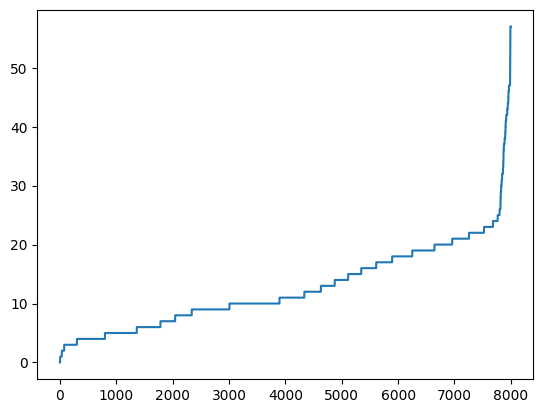

In [17]:
plt.plot((df.isnull().sum(axis = 1)).sort_values().values)

In [18]:
df = df[df.isnull().sum(axis = 1) / len(df.columns) < 0.35]
df

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.00,43.25,63.7475,104.00,15.0,37.150,72.50,NaN,NaN,NaN,NaN,15.0,73.0,49.0,70.000,110.0,18.0,37.70,100.0,NaN,NaN,NaN,15.0,77.00,55.75,77.170,121.50,20.00,37.900,217.50,NaN,NaN,NaN,-1,0,False,False,False,True
1,132540.0,76.0,True,175.3,NaN,NaN,NaN,NaN,NaN,NaN,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,NaN,13.50,80.00,51.00,70.3300,104.00,NaN,36.700,50.00,55.00,71.00,104.50,80.6,15.0,80.0,59.0,78.165,115.0,NaN,37.45,90.0,59.0,79.0,116.5,15.0,88.00,65.00,85.250,125.50,NaN,37.600,220.00,62.00,82.00,125.00,-1,0,False,True,False,False
2,132541.0,44.0,False,NaN,2.5,116.0,83.0,199.5,2.9,NaN,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,5.00,75.50,73.25,91.6700,127.00,NaN,37.250,50.00,62.25,85.25,120.50,56.7,5.0,85.5,79.0,97.670,134.0,NaN,37.85,100.0,67.0,90.0,125.0,7.0,91.00,84.00,103.000,139.75,NaN,38.175,170.00,73.50,97.75,135.25,-1,0,False,False,True,False
3,132543.0,68.0,True,180.3,4.4,105.0,12.0,15.0,0.2,NaN,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.75,61.25,80.4150,116.00,13.5,36.100,562.50,NaN,NaN,NaN,84.6,15.0,74.0,64.0,83.670,120.0,16.0,36.40,625.0,NaN,NaN,NaN,15.0,76.00,69.00,86.670,128.00,18.00,36.400,668.75,NaN,NaN,NaN,575,0,False,False,True,False
4,132545.0,88.0,False,NaN,3.3,NaN,NaN,NaN,NaN,NaN,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,68.75,38.00,70.0000,126.00,17.0,36.650,40.00,NaN,NaN,NaN,NaN,15.0,73.0,42.0,75.330,131.0,19.0,37.00,50.0,NaN,NaN,NaN,15.0,81.25,54.00,80.000,142.00,21.00,37.150,63.75,NaN,NaN,NaN,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,152849.0,78.0,True,180.3,NaN,NaN,NaN,NaN,NaN,NaN,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,10.00,98.00,52.00,79.1650,133.50,NaN,36.625,40.00,58.00,75.50,111.00,88.7,15.0,103.0,56.0,83.330,143.0,NaN,36.85,80.0,62.0,83.0,130.0,15.0,105.50,62.50,90.500,148.00,NaN,37.100,140.00,66.00,92.00,147.50,752,0,False,True,False,False
7996,152851.0,90.0,True,177.8,NaN,74.0,12.0,25.0,1.0,0.142,29.762500,54.571429,2.157143,141.714286,15.428571,1.983333,278.428571,3.542857,139.857143,28.071429,7.276667,31.666667,77.333333,NaN,True,94.333333,3.961538,3.00,79.00,34.25,54.5825,93.75,NaN,36.600,10.00,41.75,64.00,107.75,87.0,7.5,82.0,38.0,63.835,108.5,NaN,37.15,20.0,46.5,71.0,120.5,8.5,91.00,45.75,69.500,125.00,NaN,37.675,26.00,49.00,76.75,133.00,39,0,False,False,True,False
7997,152858.0,70.0,False,152.4,2.8,88.0,11.0,21.0,NaN,NaN,30.766667,29.666667,1.600000,121.333333,15.666667,1.850000,189.333333,3.866667,141.333333,14.333333,7.350000,32.000000,117.500000,NaN,False,98.000000,1.400000,14.25,69.00,56.50,80.0000,128.50,12

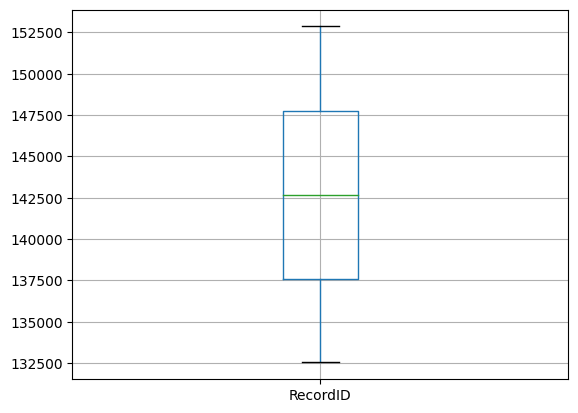

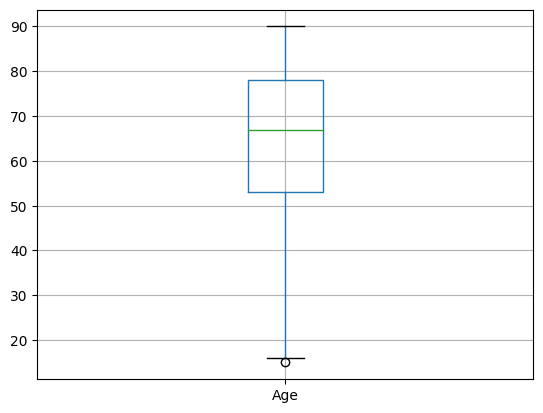

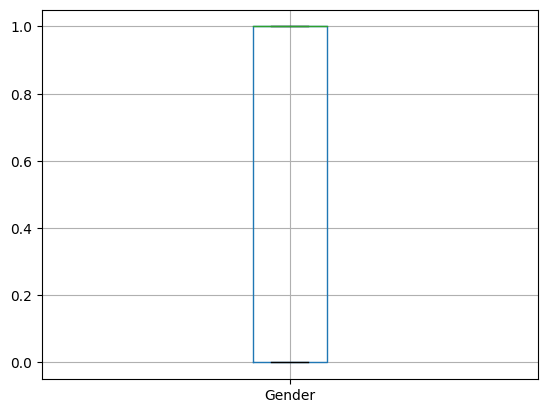

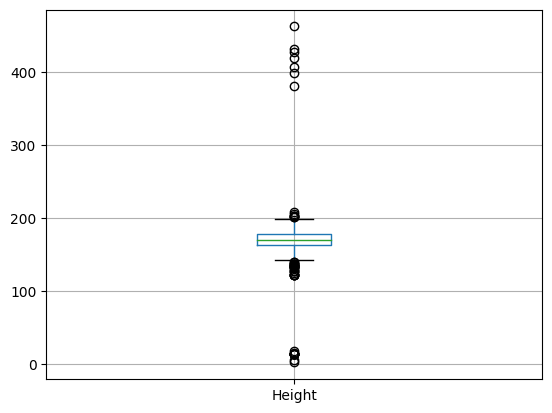

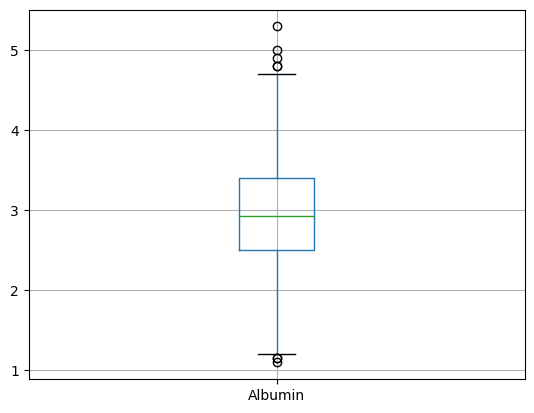

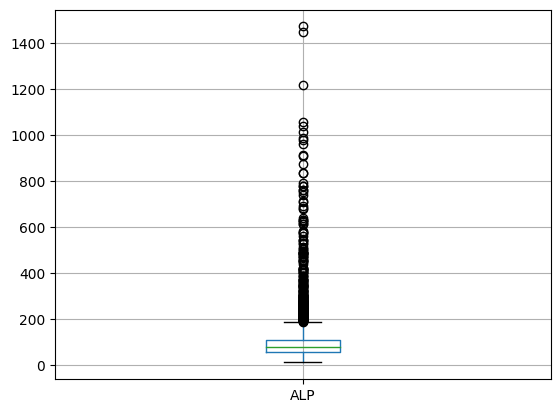

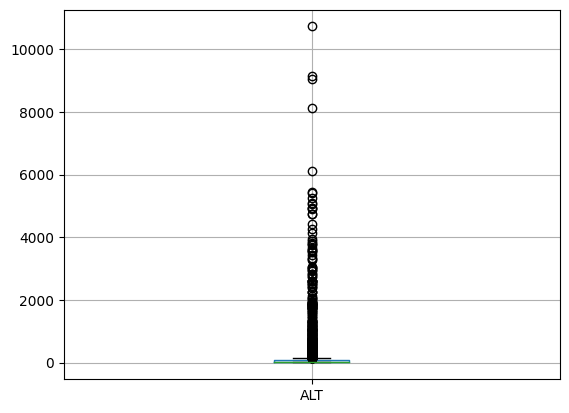

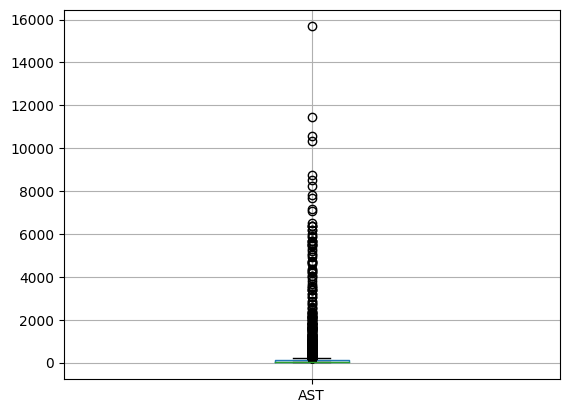

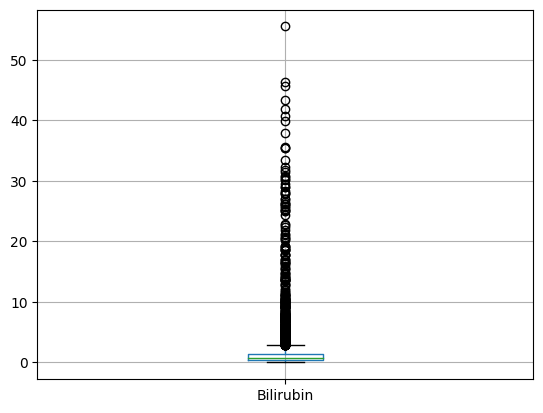

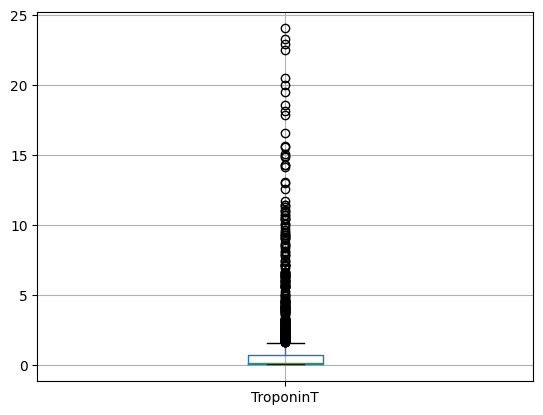

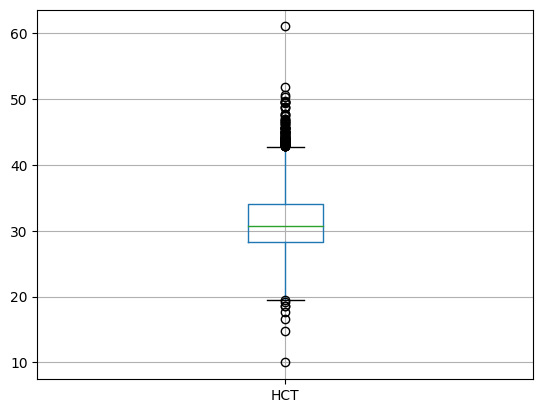

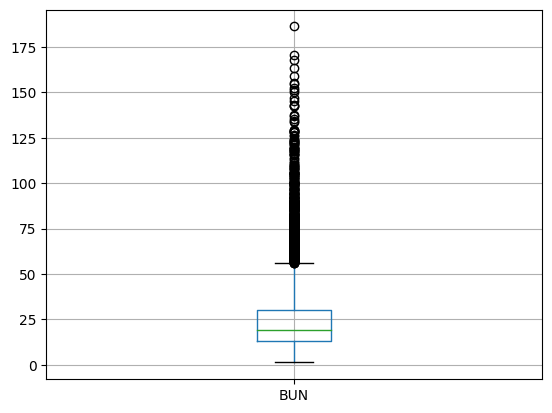

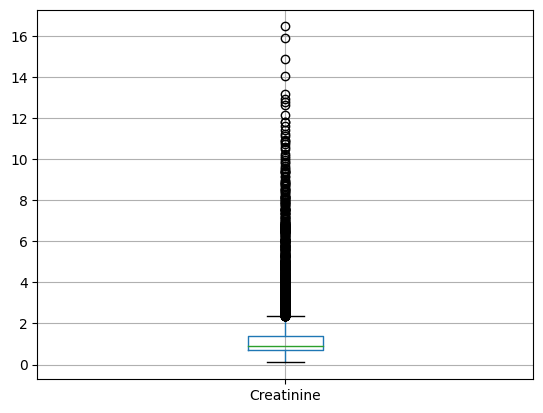

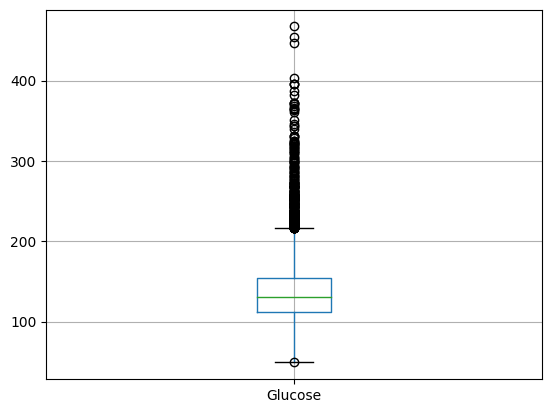

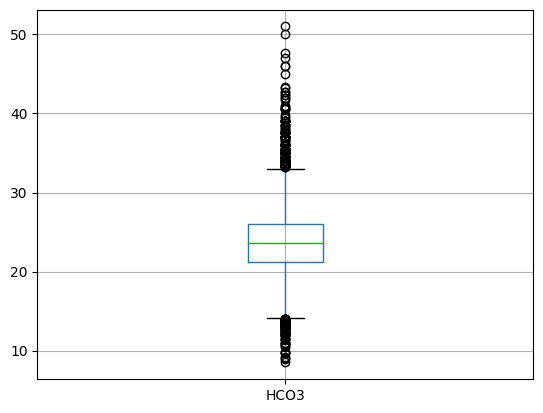

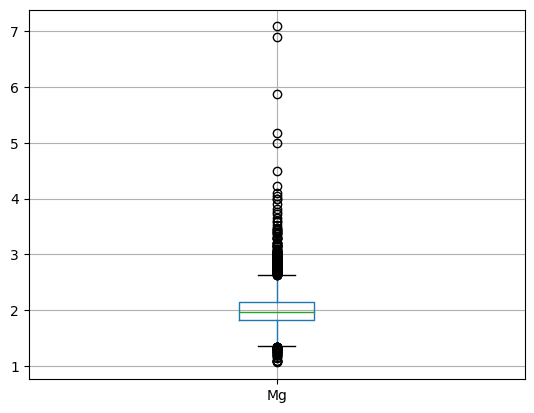

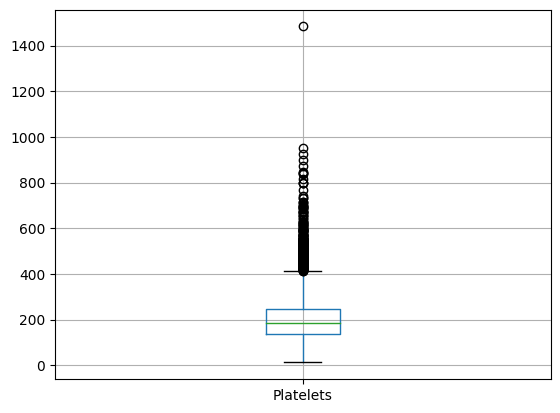

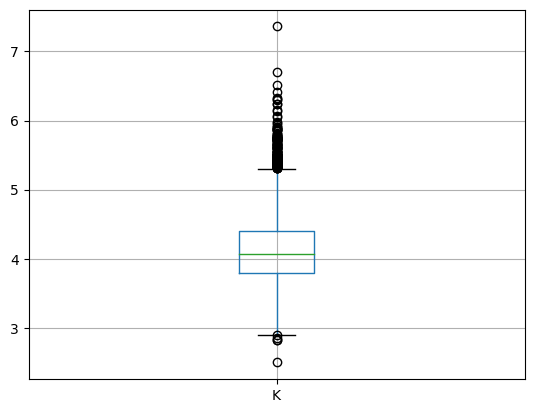

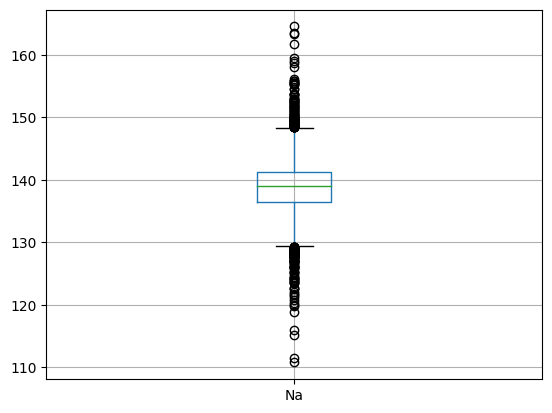

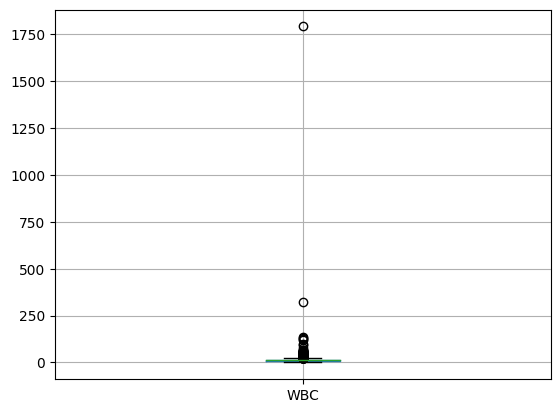

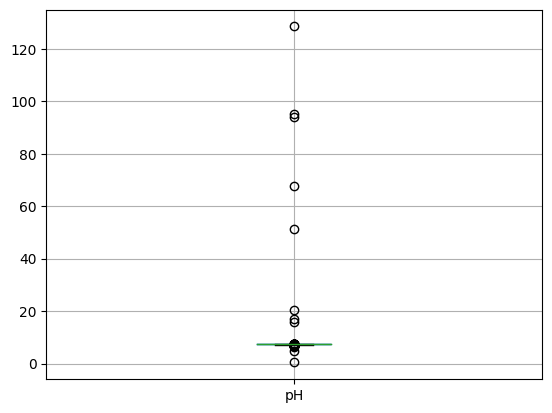

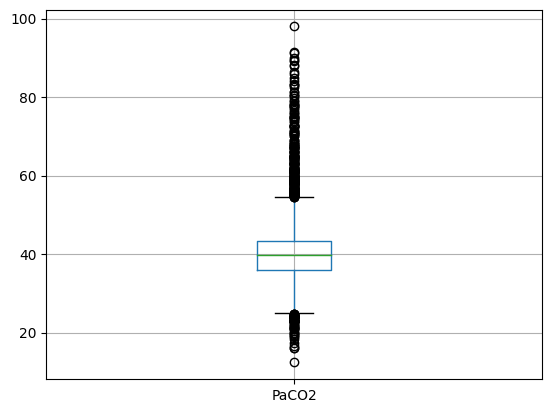

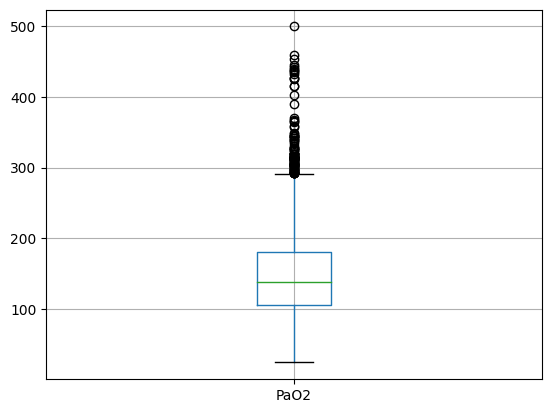

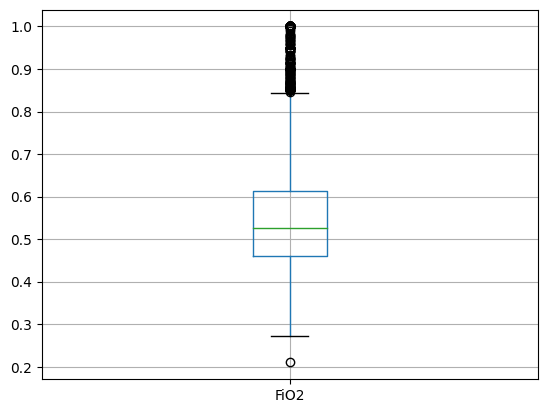

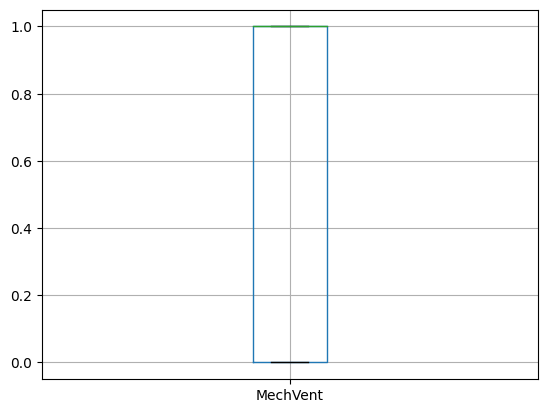

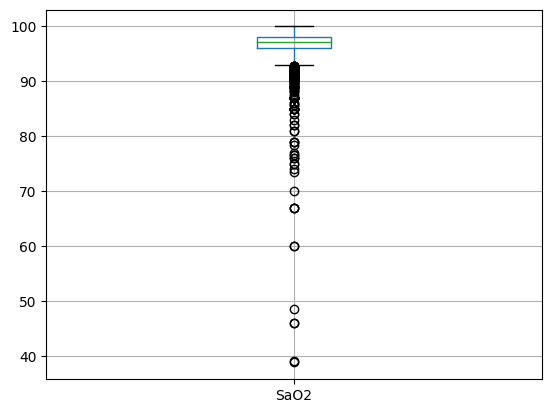

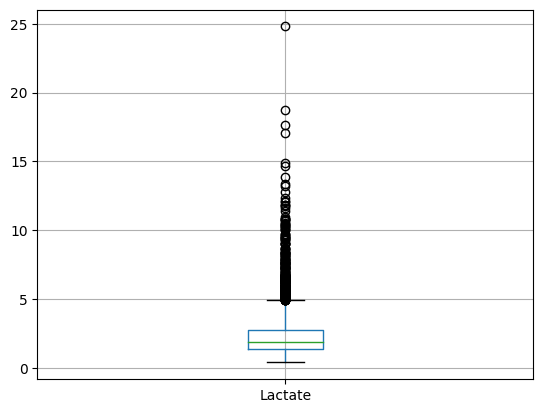

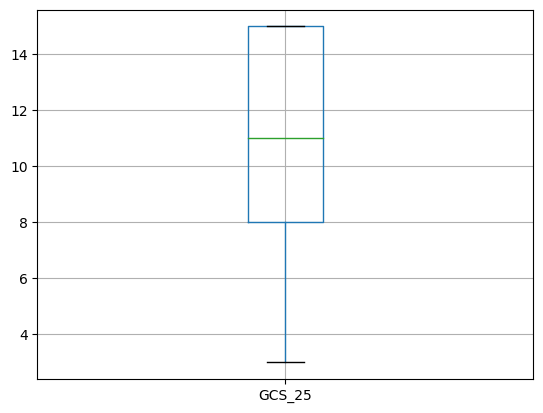

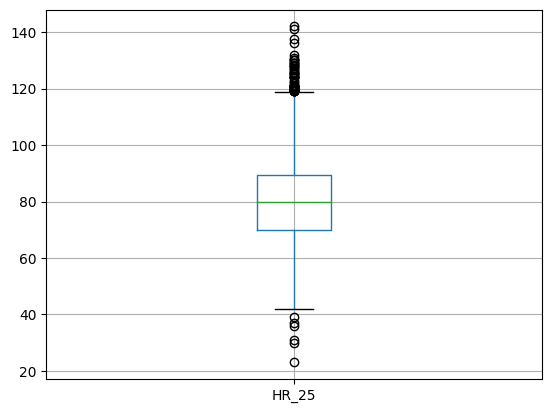

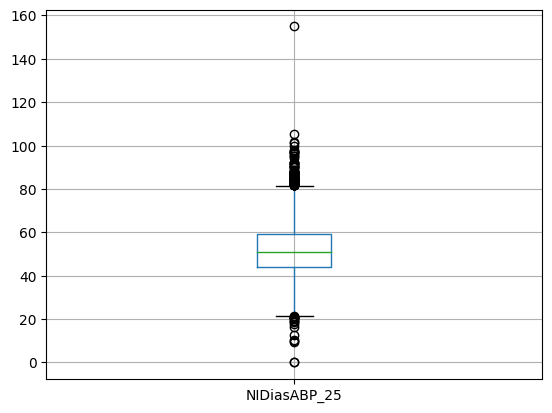

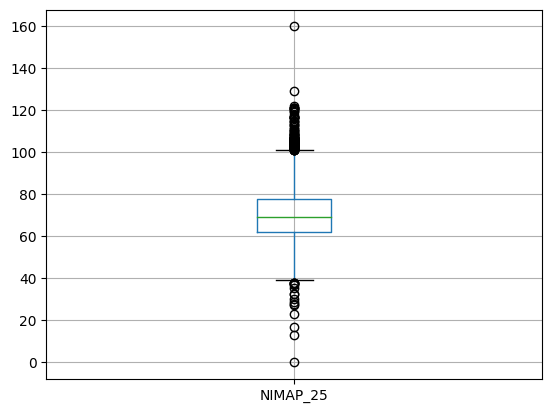

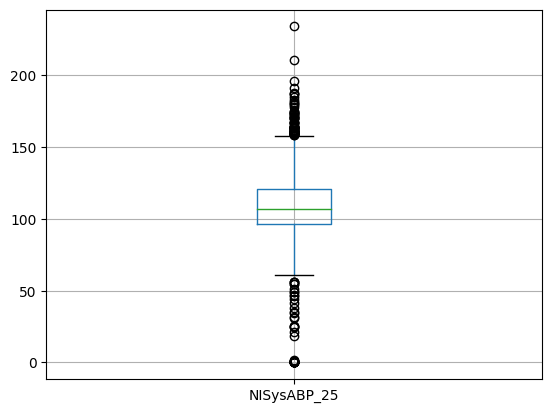

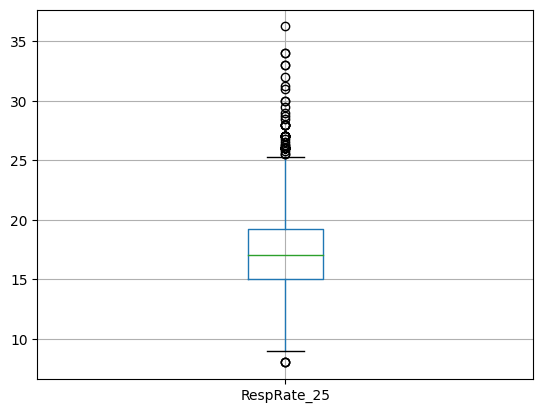

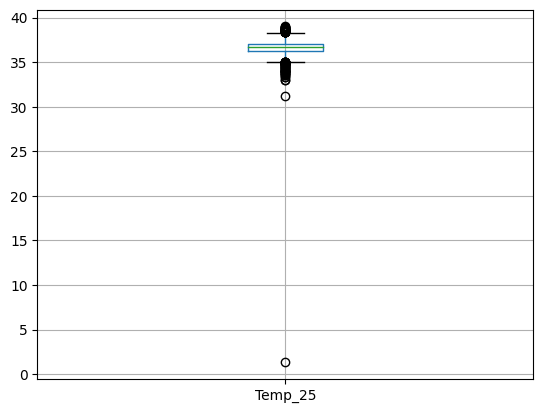

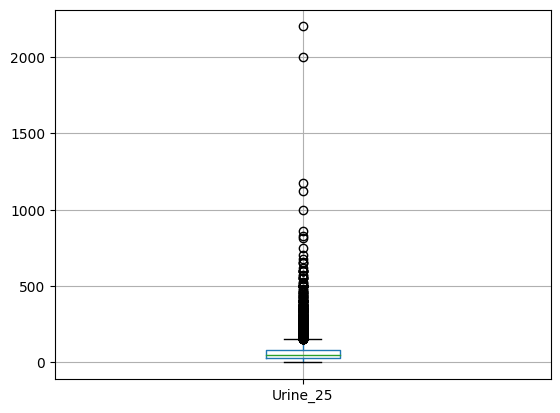

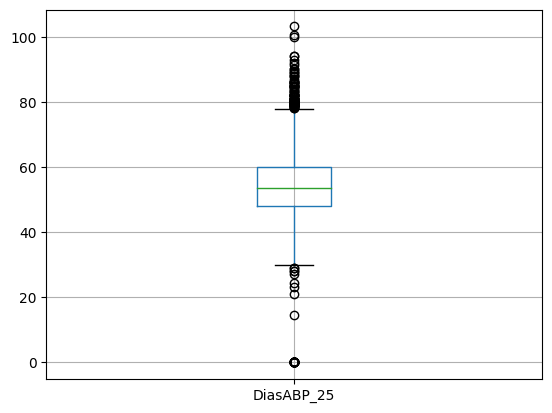

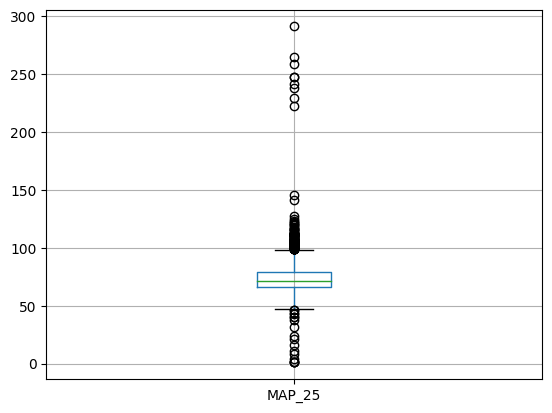

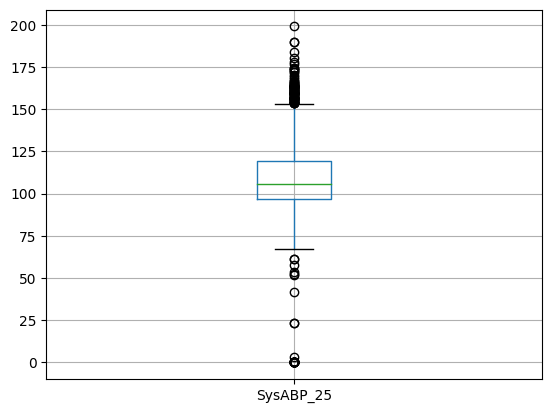

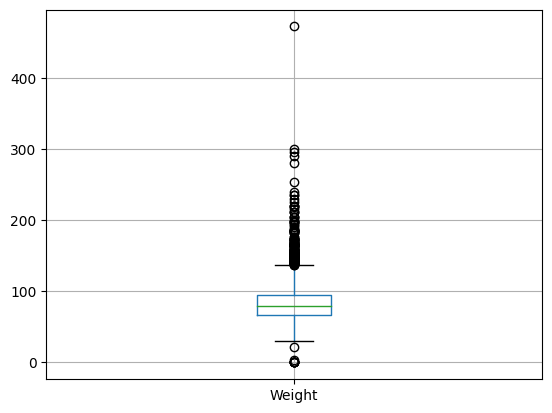

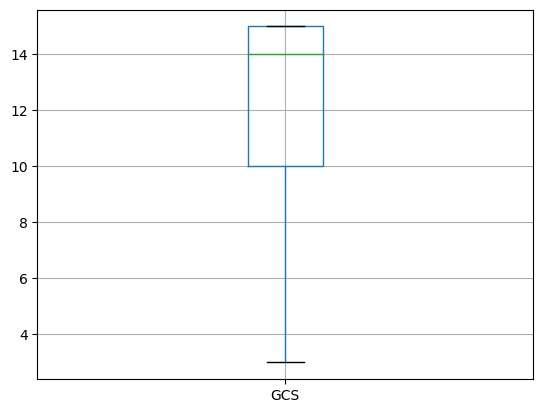

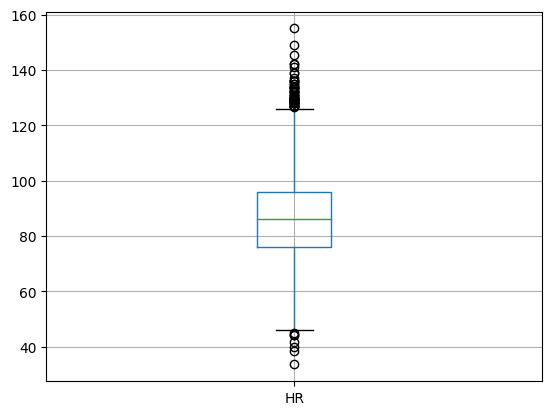

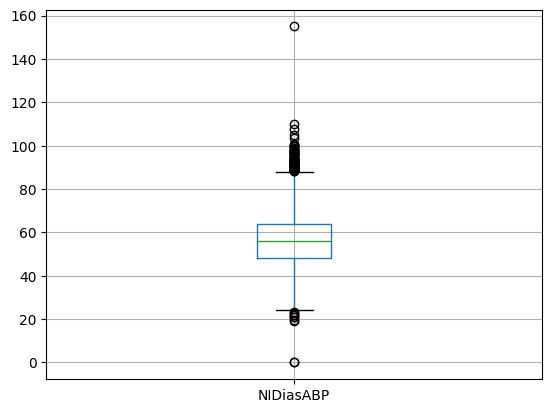

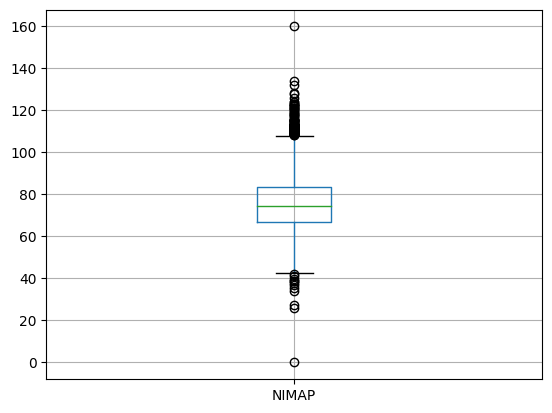

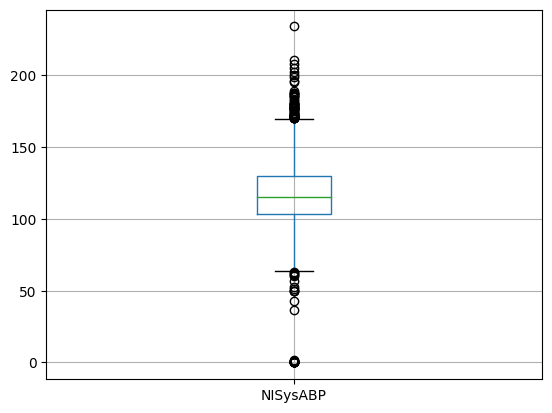

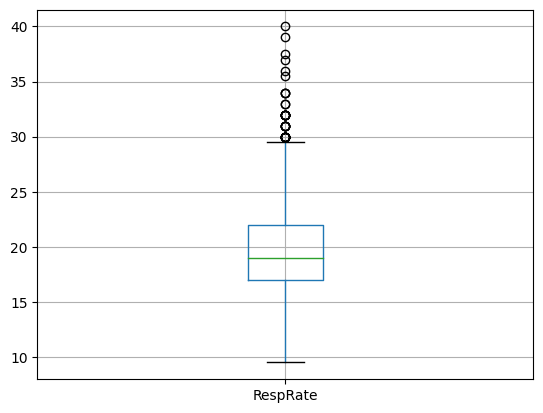

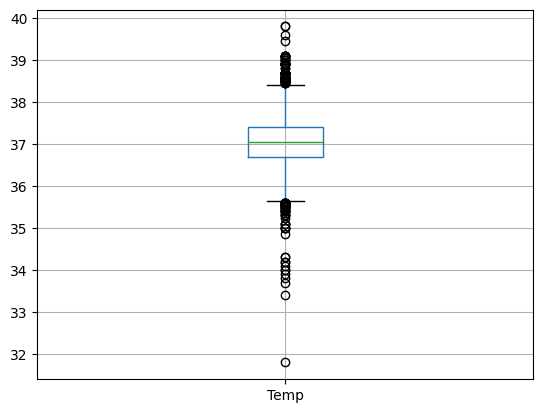

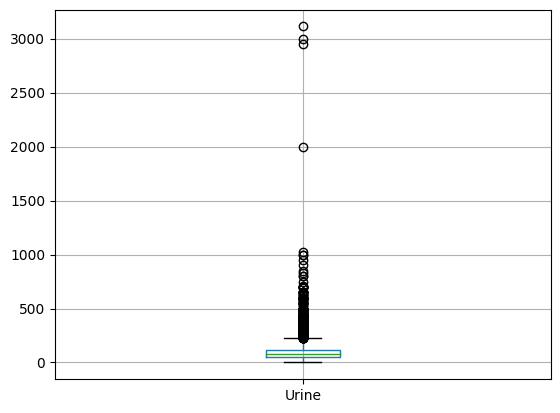

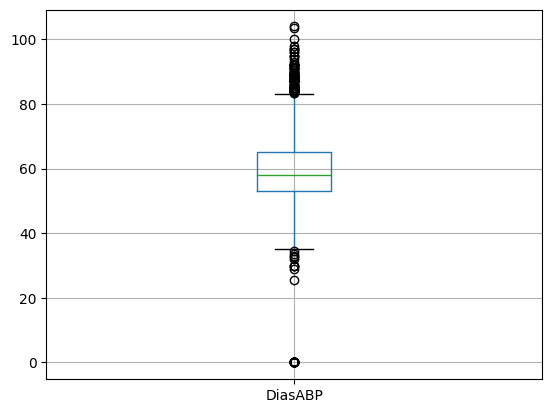

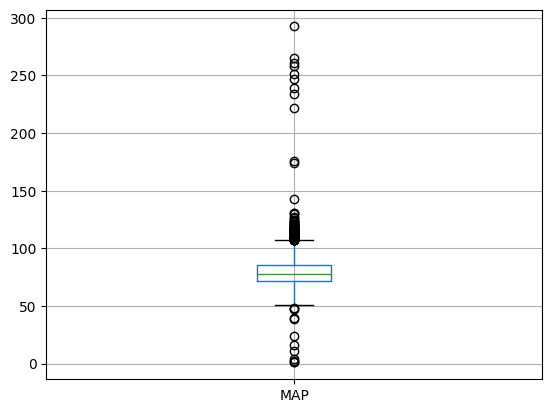

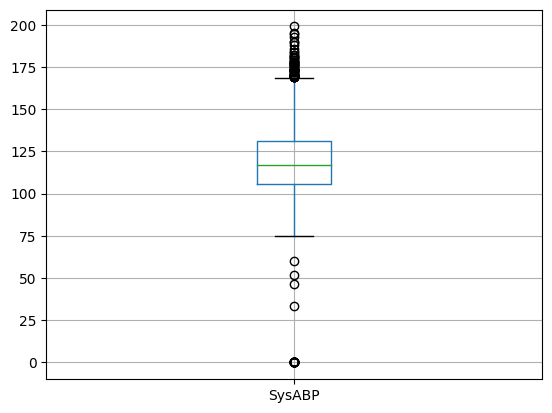

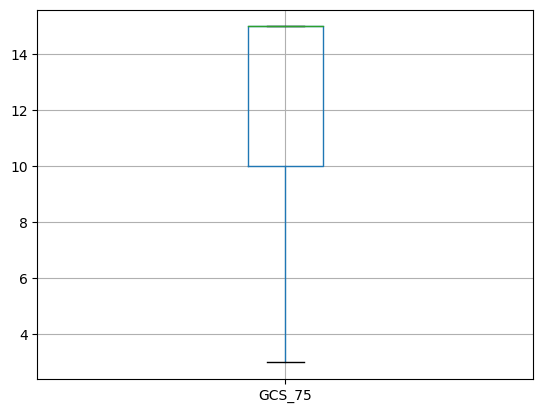

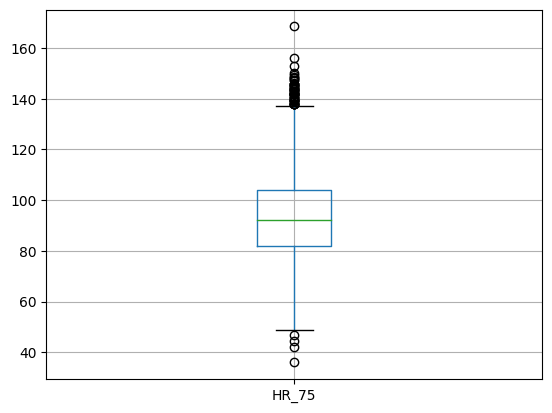

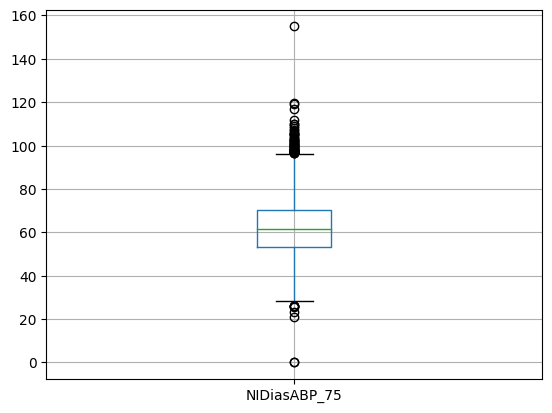

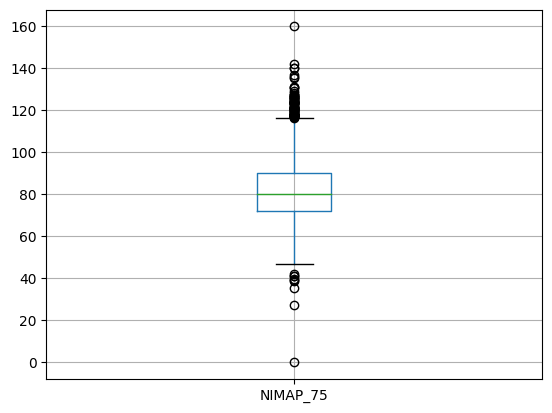

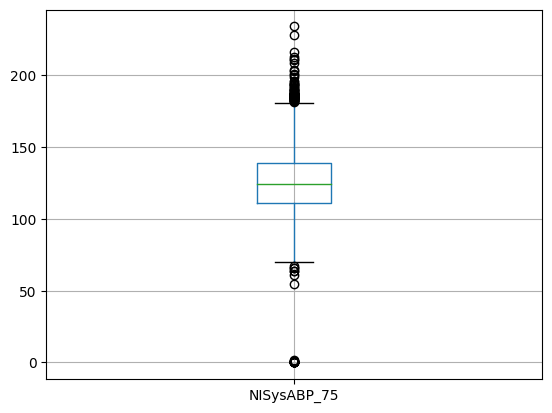

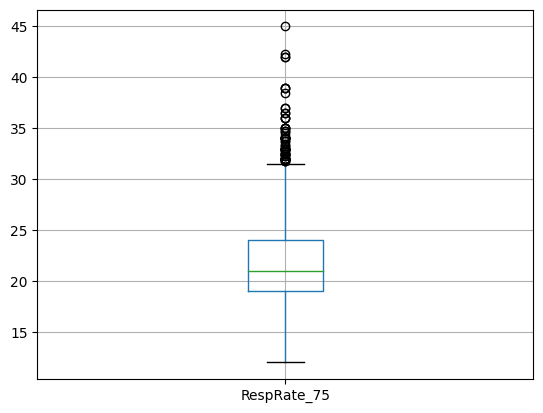

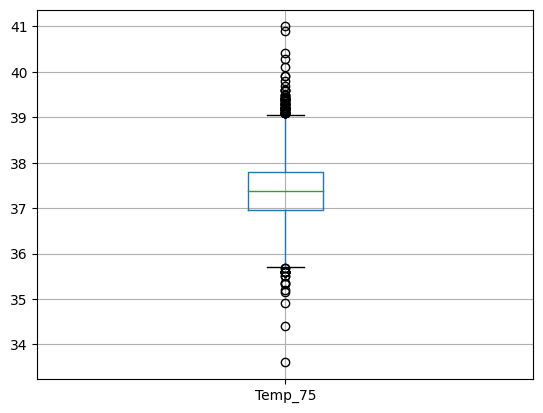

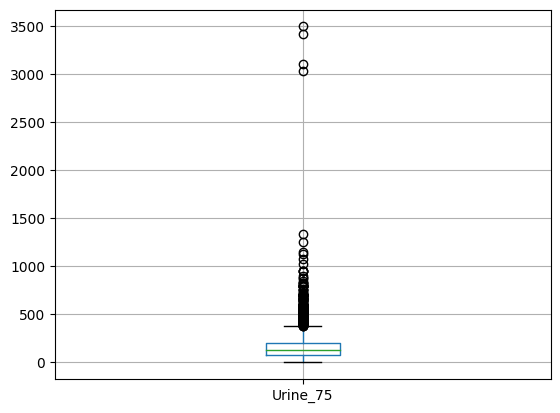

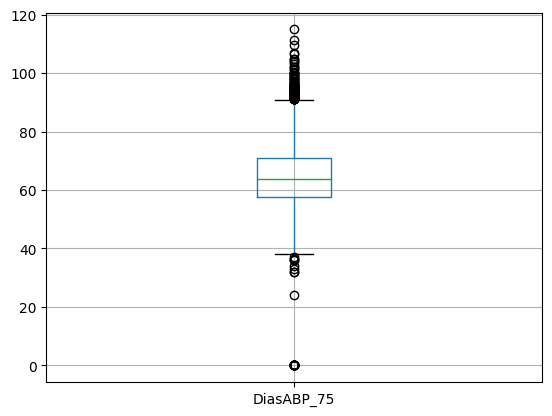

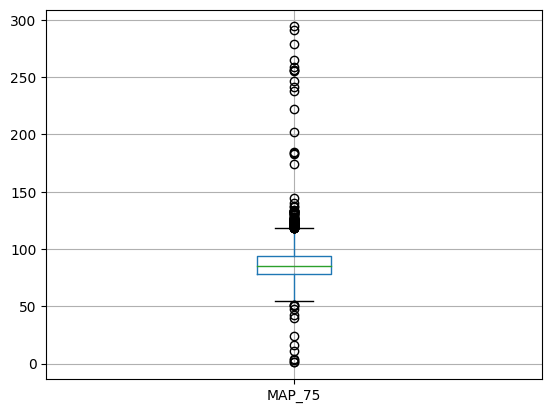

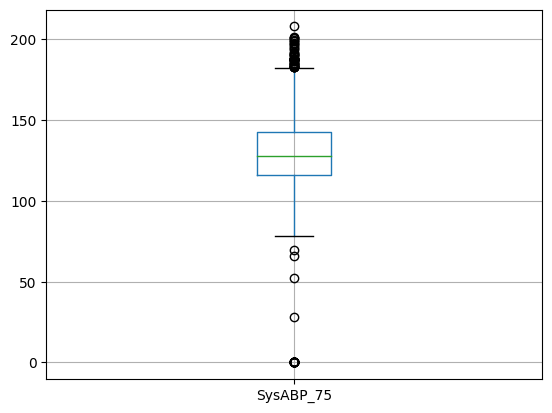

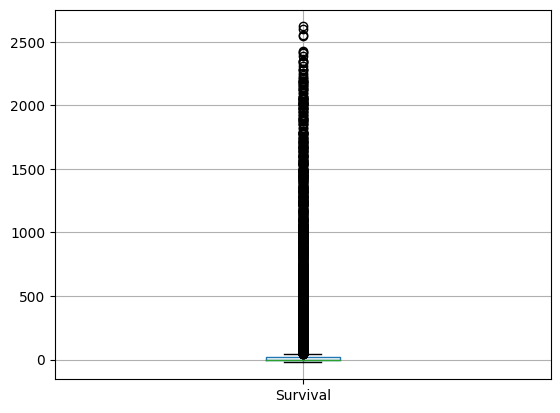

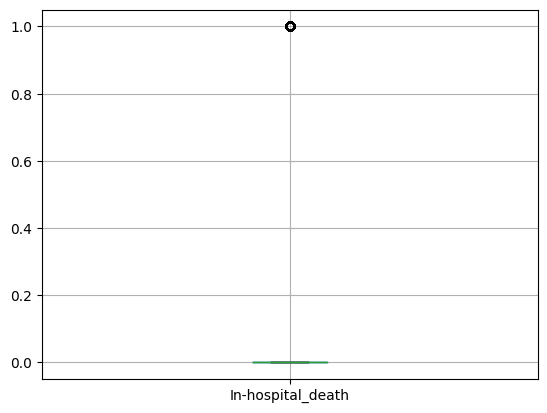

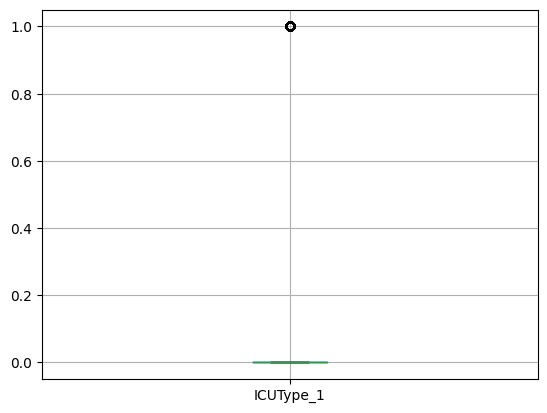

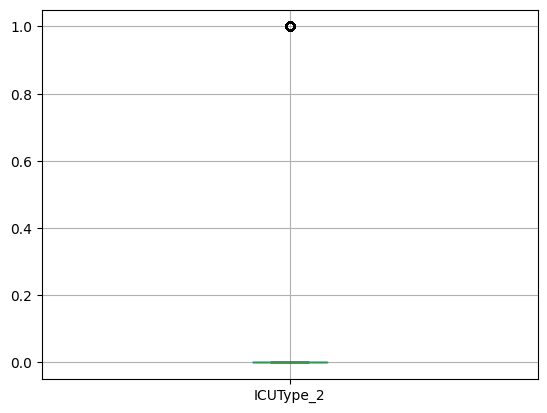

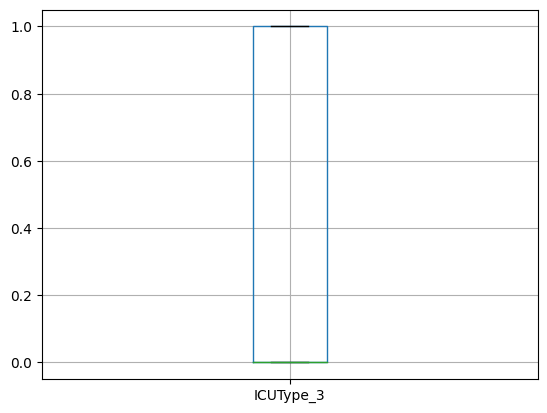

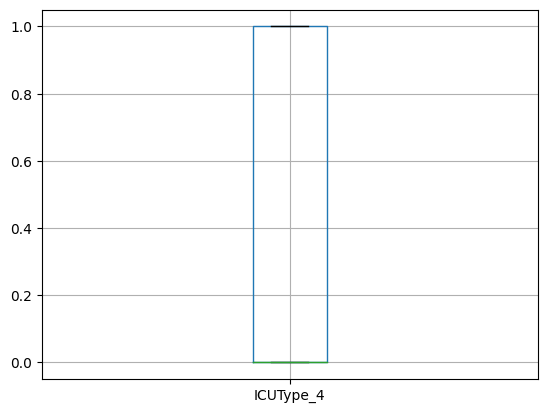

In [19]:
import matplotlib.pyplot as plt
for column in df.columns:
    plt.figure()
    df.boxplot([column])
plt.show()

Аномалии - значения, которые находятся вне интервала [Q1 - (Q3 - Q1) * 1.5; Q3 + (Q3 - Q1) * 1.5], изображаются точками на графике "ящик с усами", но не являются выбросами (см. далее). эти значения оставляем без изменения, так как они могут помочь при обучении.
Под выбросами понимаем значения, которые находятся вне интервала [Q1 - (Q3 - Q1) * 5; Q3 + (Q3 - Q1) * 5]. Их заменяем на NaN.

In [20]:
for column in df.columns:
    if column not in ["Survival", "In-hospital_death"] and df.dtypes[column] != 'bool':
        values = df[column] 
        q1, q3 = values.quantile([0.25, 0.75])
        low  = q1 - (q3 - q1) * 5
        high = q3 + (q3 - q1) * 5
        condition = (values < low) | (values > high)
        values[condition] = np.nan
df

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.00,43.25,63.7475,104.00,15.0,37.150,72.50,NaN,NaN,NaN,NaN,15.0,73.0,49.0,70.000,110.0,18.0,37.70,100.0,NaN,NaN,NaN,15.0,77.00,55.75,77.170,121.50,20.00,37.900,217.50,NaN,NaN,NaN,-1,0,False,False,False,True
1,132540.0,76.0,True,175.3,NaN,NaN,NaN,NaN,NaN,NaN,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,NaN,13.50,80.00,51.00,70.3300,104.00,NaN,36.700,50.00,55.00,71.00,104.50,80.6,15.0,80.0,59.0,78.165,115.0,NaN,37.45,90.0,59.0,79.0,116.5,15.0,88.00,65.00,85.250,125.50,NaN,37.600,220.00,62.00,82.00,125.00,-1,0,False,True,False,False
2,132541.0,44.0,False,NaN,2.5,116.0,83.0,199.5,2.9,NaN,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,5.00,75.50,73.25,91.6700,127.00,NaN,37.250,50.00,62.25,85.25,120.50,56.7,5.0,85.5,79.0,97.670,134.0,NaN,37.85,100.0,67.0,90.0,125.0,7.0,91.00,84.00,103.000,139.75,NaN,38.175,170.00,73.50,97.75,135.25,-1,0,False,False,True,False
3,132543.0,68.0,True,180.3,4.4,105.0,12.0,15.0,0.2,NaN,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,63.75,61.25,80.4150,116.00,13.5,36.100,NaN,NaN,NaN,NaN,84.6,15.0,74.0,64.0,83.670,120.0,16.0,36.40,NaN,NaN,NaN,NaN,15.0,76.00,69.00,86.670,128.00,18.00,36.400,668.75,NaN,NaN,NaN,575,0,False,False,True,False
4,132545.0,88.0,False,NaN,3.3,NaN,NaN,NaN,NaN,NaN,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,NaN,NaN,NaN,NaN,False,NaN,NaN,15.00,68.75,38.00,70.0000,126.00,17.0,36.650,40.00,NaN,NaN,NaN,NaN,15.0,73.0,42.0,75.330,131.0,19.0,37.00,50.0,NaN,NaN,NaN,15.0,81.25,54.00,80.000,142.00,21.00,37.150,63.75,NaN,NaN,NaN,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,152849.0,78.0,True,180.3,NaN,NaN,NaN,NaN,NaN,NaN,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,10.00,98.00,52.00,79.1650,133.50,NaN,36.625,40.00,58.00,75.50,111.00,88.7,15.0,103.0,56.0,83.330,143.0,NaN,36.85,80.0,62.0,83.0,130.0,15.0,105.50,62.50,90.500,148.00,NaN,37.100,140.00,66.00,92.00,147.50,752,0,False,True,False,False
7996,152851.0,90.0,True,177.8,NaN,74.0,12.0,25.0,1.0,0.142,29.762500,54.571429,2.157143,141.714286,15.428571,1.983333,278.428571,3.542857,139.857143,28.071429,7.276667,31.666667,77.333333,NaN,True,94.333333,3.961538,3.00,79.00,34.25,54.5825,93.75,NaN,36.600,10.00,41.75,64.00,107.75,87.0,7.5,82.0,38.0,63.835,108.5,NaN,37.15,20.0,46.5,71.0,120.5,8.5,91.00,45.75,69.500,125.00,NaN,37.675,26.00,49.00,76.75,133.00,39,0,False,False,True,False
7997,152858.0,70.0,False,152.4,2.8,88.0,11.0,21.0,NaN,NaN,30.766667,29.666667,1.600000,121.333333,15.666667,1.850000,189.333333,3.866667,141.333333,14.333333,7.350000,32.000000,117.500000,NaN,False,98.000000,1.400000,14.25,69.00,56.50,80.0000,128.50,12.0,36

# 2.4. Получение описательных статистик и графиков распределения всех признаков из итогового набора полей

Описательные статистики итогового датасета

In [21]:
df.describe()

,RecordID,Age,Height,Albumin,ALP,ALT,AST,Bilirubin,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,SaO2,Lactate,GCS_25,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,GCS,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,GCS_75,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death
count,7683.000000,7683.000000,4105.000000,3181.000000,3240.000000,3142.000000,3161.000000,3182.000000,1622.000000,7627.000000,7582.000000,7380.000000,7538.000000,7617.000000,7560.000000,7615.000000,7583.000000,7615.000000,7589.000000,5980.000000,5937.000000,5957.000000,5352.000000,3485.000000,4299.000000,7683.000000,7683.000000,6822.000000,6818.000000,6849.000000,2182.000000,7681.000000,7491.000000,5593.000000,5572.000000,5593.000000,7226.000000,7683.000000,7683.000000,6822.000000,6819.000000,6849.000000,2182.000000,7682.000000,7539.000000,5593.000000,5569.000000,5593.000000,7683.000000,7683.000000,6823.000000,6819.000000,6849.000000,2182.000000,7683.000000,7593.000000,5593.000000,5566.000000,5593.000000,7683.000000,7683.000000
mean,142677.959911,64.509567,169.733228,2.949974,91.739775,50.296913,76.272514,1.035829,0.409702,31.392485,24.735608,1.142557,137.071227,23.623616,2.010087,202.481341,4.131055,138.929001,12.362488,7.383806,40.177013,147.648777,0.551641,96.824680,2.277128,10.796434,80.213068,51.756486,70.568196,109.188341,17.215284,36.660171,59.734715,54.202217,73.234476,108.676873,83.006583,11.977808,86.459000,56.810246,76.003124,117.274091,19.453254,37.053189,94.279148,59.129358,79.752649,119.045414,12.719543,93.399974,62.422761,81.790538,125.591371,21.817026,37.393027,154.828964,64.522081,86.797422,129.546487,131.003644,0.141872
std,5856.561863,17.244962,10.828669,0.632520,54.479633,57.339763,90.256704,1.060597,0.670212,4.514478,18.371289,0.729682,37.936877,4.070789,0.291409,99.521202,0.480575,4.092814,5.436538,0.055938,7.387085,56.814274,0.132458,1.855139,1.400941,4.008402,14.513189,11.639951,12.085260,19.918264,3.665242,0.605232,48.807757,10.473151,11.023050,19.750466,23.626709,3.611764,15.155394,12.122022,12.597705,20.626928,4.011631,0.598481,72.978039,10.764859,11.534151,20.404789,3.245689,16.210233,12.953454,13.445884,21.804194,4.388965,0.630457,111.069698,11.548090,12.625341,21.830649,365.391153,0.348941
min,132539.000000,15.000000,121.900000,1.100000,12.000000,3.000000,6.000000,0.000000,0.010000,10.000000,1.285714,0.100000,49.000000,8.500000,1.066667,12.166667,2.500000,115.153846,0.075000,7.100000,12.400000,24.000000,0.210000,86.000000,0.400000,3.000000,23.000000,0.000000,0.000000,0.000000,8.000000,33.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,33.500000,0.000000,0.000000,0.000000,9.500000,33.400000,0.000000,0.000000,2.000000,0.000000,3.000000,36.000000,0.000000,0.000000,0.000000,12.000000,33.600000,0.000000,0.000000,1.000000,0.000000,-23.000000,0.000000
25%,137596.500000,53.000000,162.600000,2.500000,57.000000,17.000000,24.000000,0.400000,0.040000,28.253571,13.000000,0.700000,112.000000,21.250000,1.833333,135.333333,3.800000,136.500000,8.800000,7.352286,36.000000,105.500000,0.460000,96.125000,1.333333,8.000000,70.000000,44.000000,62.000000,96.250000,15.000000,36.275000,30.000000,48.000000,66.000000,97.000000,67.000000,10.000000,76.000000,48.000000,67.000000,103.500000,17.000000,36.700000,45.000000,53.000000,72.000000,106.000000,10.000000,82.000000,53.250000,72.330000,111.000000,19.000000,36.950000,80.000000,57.750000,78.000000,115.750000,-1.000000,0.000000
50%,142688.000000,67.000000,170.200000,2.933333,76.000000,28.500000,42.000000,0.650000,0.110000,30.660000,18.750000,0.900000,129.916667,23.666667,1.975000,185.750000,4.066667,139.000000,11.550000,7.388000,39.666667,138.000000,0.526667,97.250000,1.883333,11.000000,79.750000,50.750000,69.080000,107.000000,17.000000,36.675000,45.000000,53.500000,71.000000,106.000000,80.000000,14.000000,86.0000

In [22]:
df["Survival"][df["Survival"] < -1] = -1

Строим гистаграммы по значениям в колонках

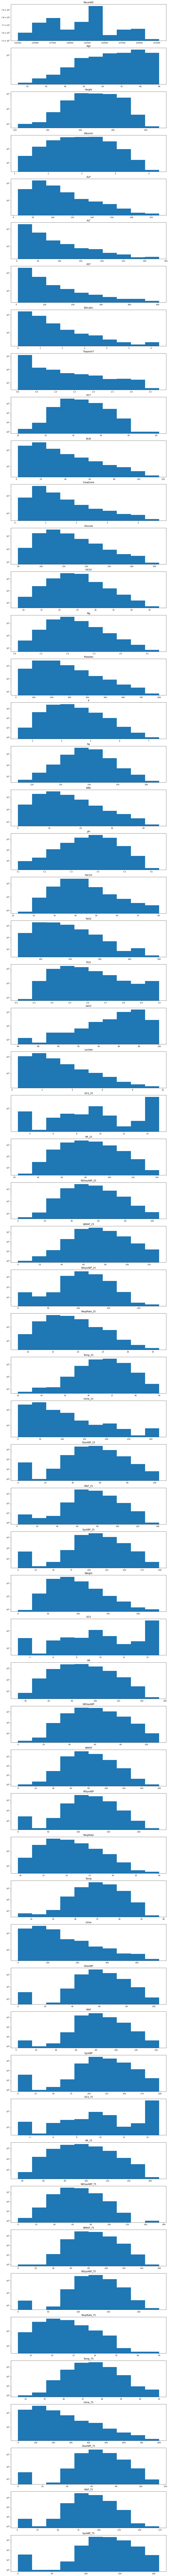

In [23]:
data = df.to_numpy()
figure, axis = plt.subplots((df.dtypes=='float64').sum(), 1)
figure.set_size_inches(15, 250)
i = 0
for column in df.columns:
    if df.dtypes[column]=='float64':
        s = pd.Series(data[:, df.columns.get_loc(column)])
        axis[i].hist(s, bins = 10, log = True)
        axis[i].set_title(column)
        i += 1
plt.show()

Проверяем, насколько распределение для каждого признака для не-NaN значений является нормальным, логнормальным, экпоненциальным или равномерным, используя библиотеку fitter, в которой подбираются парааметры для каждого из распределений, минимизируя RSS (сумма квадратов ошибок от распределения) по гистограмме из 15 интервалов (при большем количестве интервалов могут проявиться некорректные результаты из-за работы с целыми числами в некоторых признаках, например, рост или возраст, когда в интервал может не попасть ни одного значения).

Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.86it/s]


RecordID
uniform    1.738733e-11
norm       4.578791e-09
expon      9.078465e-09
lognorm    2.927057e-08
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.25it/s]


Age
norm       0.000358
lognorm    0.000377
uniform    0.000932
expon      0.002371
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.05it/s]


Height
norm       0.000121
lognorm    0.000122
uniform    0.002600
expon      0.003633
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.32it/s]


Albumin
norm       0.025424
lognorm    0.025812
uniform    0.719638
expon      1.021792
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 48.72it/s]


ALP
norm       0.000079
expon      0.000146
uniform    0.000225
lognorm    0.000284
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.15it/s]


ALT
lognorm    0.000010
expon      0.000020
norm       0.000263
uniform    0.000434
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.67it/s]


AST
lognorm    0.000005
expon      0.000013
norm       0.000132
uniform    0.000205
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 66.16it/s]


Bilirubin
lognorm    0.016966
expon      0.100489
norm       0.422316
uniform    0.880850
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 97.53it/s]


TroponinT
lognorm    1.062532
expon      1.197409
norm       4.970093
uniform    6.500440
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.11it/s]


HCT
lognorm    0.000268
norm       0.000887
uniform    0.013504
expon      0.015710
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.22it/s]


BUN
lognorm    0.000036
norm       0.000928
expon      0.001033
uniform    0.002198
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.89it/s]


Creatinine
lognorm    0.068557
norm       0.661228
expon      1.035471
uniform    1.506800
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.68it/s]


Glucose
norm       0.000039
expon      0.000270
uniform    0.000281
lognorm    0.000430
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


HCO3
norm       0.000652
lognorm    0.000702
uniform    0.019512
expon      0.022499
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.62it/s]


Mg
lognorm    0.060961
norm       0.225221
uniform    3.983363
expon      4.460016
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.90it/s]


Platelets
lognorm    3.820016e-07
norm       4.364444e-06
expon      3.078890e-05
uniform    3.979818e-05
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.43it/s]


K
lognorm    0.012294
norm       0.060069
uniform    1.311991
expon      1.437074
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 47.07it/s]


Na
norm       0.000249
uniform    0.016361
expon      0.019246
lognorm    0.026854
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.92it/s]


WBC
lognorm    0.000146
norm       0.001079
expon      0.011630
uniform    0.012533
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.08it/s]


pH
lognorm      2.242571
norm         2.282994
uniform     97.104260
expon      124.193402
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.09it/s]


PaCO2
lognorm    0.000443
norm       0.000646
uniform    0.007101
expon      0.008252
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.73it/s]


PaO2
lognorm    8.401482e-07
norm       1.013630e-05
expon      9.009600e-05
uniform    1.041249e-04
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 61.61it/s]


FiO2
lognorm     0.693789
norm        4.009158
uniform    23.679486
expon      31.306859
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.13it/s]


SaO2
norm       0.053223
lognorm    0.054266
uniform    0.176561
expon      0.224268
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 61.11it/s]


Lactate
lognorm    0.000483
norm       0.095034
expon      0.135886
uniform    0.307269
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.11it/s]


GCS_25
uniform    0.143843
norm       0.157193
lognorm    0.157649
expon      0.189271
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.93it/s]


HR_25
lognorm    0.000002
norm       0.000011
uniform    0.001381
expon      0.001848
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.36it/s]


NIDiasABP_25
lognorm    0.000017
norm       0.000064
uniform    0.002232
expon      0.002850
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.31it/s]


NIMAP_25
lognorm    0.000023
norm       0.000071
uniform    0.001939
expon      0.002409
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.59it/s]


NISysABP_25
lognorm    0.000030
norm       0.000032
uniform    0.000723
expon      0.000846
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.62it/s]


RespRate_25
lognorm    0.000392
norm       0.001804
uniform    0.026448
expon      0.028367
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.22it/s]


Temp_25
norm       0.003612
lognorm    0.003793
uniform    0.776414
expon      1.015528
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.07it/s]


Urine_25
lognorm    0.000017
norm       0.000123
expon      0.000139
uniform    0.000323
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.21it/s]


DiasABP_25
lognorm    0.000187
norm       0.000196
uniform    0.003125
expon      0.003824
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.97it/s]


MAP_25
lognorm    0.000089
norm       0.000125
uniform    0.002206
expon      0.002588
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.58it/s]


SysABP_25
norm       0.000123
uniform    0.000978
expon      0.001175
lognorm    0.001467
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.43it/s]


Weight
lognorm    0.000003
norm       0.000031
uniform    0.000584
expon      0.000649
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.62it/s]


GCS
norm       0.279324
lognorm    0.279699
uniform    0.287712
expon      0.343797
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.26it/s]


HR
lognorm    0.000006
norm       0.000027
uniform    0.001307
expon      0.001684
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.38it/s]


NIDiasABP
lognorm    0.000028
norm       0.000067
uniform    0.002034
expon      0.002644
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.13it/s]


NIMAP
lognorm    0.000015
norm       0.000050
uniform    0.001579
expon      0.001851
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.71it/s]


NISysABP
lognorm    0.000032
norm       0.000033
uniform    0.000676
expon      0.000809
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 59.67it/s]


RespRate
lognorm    0.000120
norm       0.001316
uniform    0.020812
expon      0.022776
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.28it/s]


Temp
lognorm    0.012302
norm       0.013238
uniform    0.723539
expon      0.920912
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.22it/s]


Urine
norm       0.000042
expon      0.000053
uniform    0.000124
lognorm    0.000141
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.81it/s]


DiasABP
lognorm    0.000156
norm       0.000160
uniform    0.002982
expon      0.003725
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.39it/s]


MAP
lognorm    0.000160
norm       0.000225
uniform    0.002140
expon      0.002540
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.97it/s]


SysABP
lognorm    0.000057
norm       0.000058
uniform    0.000814
expon      0.001024
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.37it/s]


GCS_75
norm       0.410975
lognorm    0.411194
uniform    0.445066
expon      0.505919
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.47it/s]


HR_75
lognorm    0.000004
norm       0.000006
uniform    0.001086
expon      0.001404
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.55it/s]


NIDiasABP_75
lognorm    0.000001
norm       0.000013
uniform    0.001490
expon      0.001719
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.45it/s]


NIMAP_75
lognorm    0.000011
norm       0.000038
uniform    0.001415
expon      0.001706
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.27it/s]


NISysABP_75
lognorm    0.000008
norm       0.000017
uniform    0.000603
expon      0.000744
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 45.00it/s]


RespRate_75
lognorm    0.000267
norm       0.001073
expon      0.017369
uniform    0.017588
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


Temp_75
lognorm    0.006324
norm       0.007743
uniform    0.631332
expon      0.768585
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.03it/s]


Urine_75
norm       0.000008
expon      0.000015
uniform    0.000040
lognorm    0.000046
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.87it/s]


DiasABP_75
lognorm    0.000118
norm       0.000123
uniform    0.002501
expon      0.003106
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.90it/s]


MAP_75
lognorm    0.000052
norm       0.000080
uniform    0.001558
expon      0.001802
Name: sumsquare_error, dtype: float64


Fitting 4 distributions: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.60it/s]


SysABP_75
norm       0.000029
uniform    0.000700
expon      0.000898
lognorm    0.001158
Name: sumsquare_error, dtype: float64


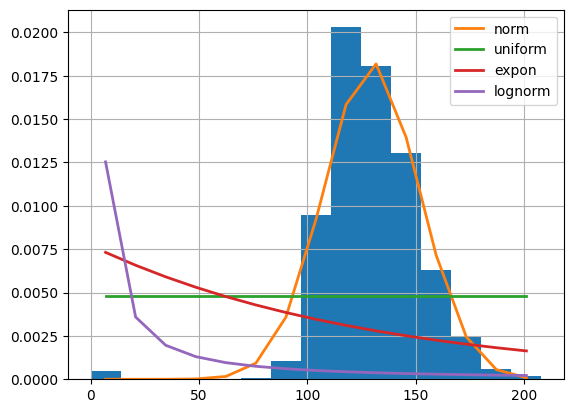

In [24]:
i = 0
f = [None] * (df.dtypes=='float64').sum()
for column in df.columns:
    if df.dtypes[column]=='float64':
        f[i] = Fitter(df[column][~df[column].isnull()],
                   distributions=["expon", "uniform", "norm", "lognorm"],
                   bins = 15)
        time.sleep(0.2)
        f[i].fit()
        print(column)
        print(f[i].summary()['sumsquare_error'])
        i += 1  

Во всех признаках, кроме указанных ниже, меньшая ошибка была при расчёте для нормального или логнормального распределения. Так как нормальное распределение предполагает возможность отрицательных значений, а логнормальное нет, то между этих двух будем выбирать логнормальное.

RecordID - равномерное: логично, так как номера ID указываются в равномерном порядке по нарастанию (с некоторыми пропусками).
GCS, GCS_25, GCS_75 - sumsquare_error показывает большую ошибку для любого распределения: по графику видно, что в данных признаках не сформированно хоть какое-то распределение, поэтому предлагается исключить данные признаки из датасета.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.025424,75.052667,-37319.302654,0.011305,0.044487,6.575861e-06
lognorm,0.025812,76.342124,-37263.099197,0.011504,0.043656,1.048556e-05
uniform,0.719638,47.052536,-26685.048439,1.001526,0.276433,2.295973e-215
expon,1.021792,56.509681,-25569.903466,1.027661,0.342752,0.000000e+00


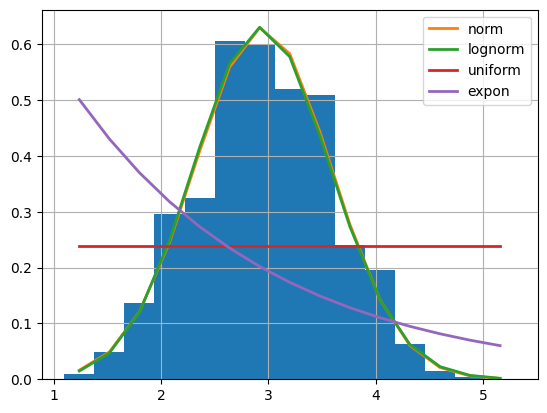

In [25]:
# График для Height - пример нормального/логнормального распределения
f[3].summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000005,236.152690,-64262.838055,0.015430,0.042841,1.769374e-05
expon,0.000013,238.120905,-61013.442260,0.062721,0.114056,2.814284e-36
norm,0.000132,263.940557,-53693.328537,0.444705,0.226612,3.927927e-143
uniform,0.000205,190.388201,-52304.448264,1.093835,0.609747,0.000000e+00


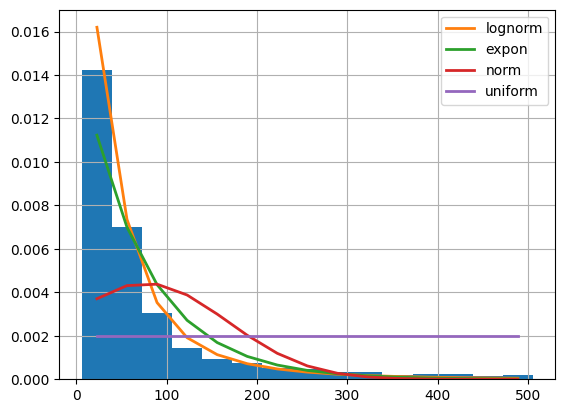

In [26]:
# График для ALT - пример экспоненциального/логнормального распределения
f[6].summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
uniform,0.143843,78.547199,-83617.708333,0.460320,0.319667,0.000000e+00
norm,0.157193,87.385729,-82935.817675,0.489382,0.189337,1.198024e-241
lognorm,0.157649,89.257258,-82904.614575,0.490217,0.192080,9.581668e-249
expon,0.189271,88.697471,-81509.056040,0.692409,0.233693,0.000000e+00


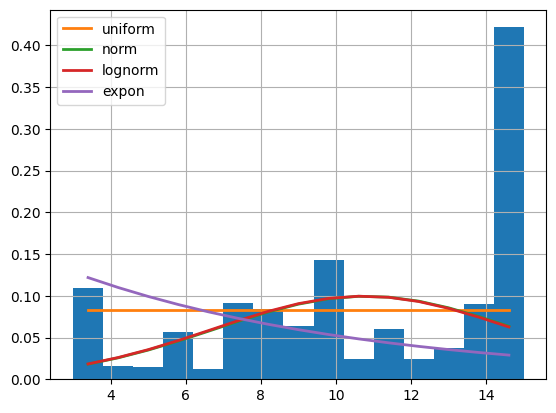

In [27]:
# График для GCS_25: пример с неопределённым распределением
f[25].summary()

In [28]:
df = df.drop(columns=["GCS_25", "GCS", "GCS_75"])

Заполняем NaN-значения согласно найденным распределениям, т. е. случайными величинами с известными параметрами распределений, для сохранения распределения значений.

In [29]:
for column in df.columns:
    if column not in ["RecordID"]:
        values = df[column] 
        E = values.mean()
        D = values.var()
        sigma = np.log(D / (E ** 2) + 1) ** 0.5
        mu = np.log(E) - (sigma ** 2) / 2
        condition = values.isna()
        new_values =  abs(np.random.lognormal(mu, sigma, len(df.index)))
        values[condition] = new_values[condition]
df

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,166.004972,2.999824,75.836610,27.400347,291.237037,5.739116,0.261842,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,7.365233,41.930065,100.638619,0.562844,False,100.385779,4.490527,63.00,43.250000,63.747500,104.00,15.000000,37.150,72.5000,44.821326,71.000273,73.655679,82.984193,73.0,49.000000,70.000000,110.0,18.000000,37.70,100.000000,46.549238,94.393848,105.642945,77.00,55.750000,77.170000,121.50,20.000000,37.900,217.50,73.024289,93.608061,130.256378,-1,0,False,False,False,True
1,132540.0,76.0,True,175.300000,4.323835,70.704609,9.803650,92.074943,0.086678,0.031235,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,0.630535,80.00,51.000000,70.330000,104.00,18.015870,36.700,50.0000,55.000000,71.000000,104.500000,80.600000,80.0,59.000000,78.165000,115.0,17.846696,37.45,90.000000,59.000000,79.000000,116.500000,88.00,65.000000,85.250000,125.50,18.249919,37.600,220.00,62.000000,82.000000,125.000000,-1,0,False,True,False,False
2,132541.0,44.0,False,191.066165,2.500000,116.000000,83.000000,199.500000,2.900000,0.279851,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,75.50,73.250000,91.670000,127.00,28.270886,37.250,50.0000,62.250000,85.250000,120.500000,56.700000,85.5,79.000000,97.670000,134.0,19.504222,37.85,100.000000,67.000000,90.000000,125.000000,91.00,84.000000,103.000000,139.75,29.026320,38.175,170.00,73.500000,97.750000,135.250000,-1,0,False,False,True,False
3,132543.0,68.0,True,180.300000,4.400000,105.000000,12.000000,15.000000,0.200000,0.158444,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,7.450384,44.587909,151.841629,0.515453,False,95.711903,2.283417,63.75,61.250000,80.415000,116.00,13.500000,36.100,55.1423,62.418769,50.200187,99.940145,84.600000,74.0,64.000000,83.670000,120.0,16.000000,36.40,120.860943,79.549038,77.776137,125.048898,76.00,69.000000,86.670000,128.00,18.000000,36.400,668.75,59.412851,76.876189,149.011645,575,0,False,False,True,False
4,132545.0,88.0,False,171.506198,3.300000,215.507707,12.149334,71.285832,1.587533,0.594917,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,7.410338,41.684916,68.117953,0.477404,False,96.161964,1.207675,68.75,38.000000,70.000000,126.00,17.000000,36.650,40.0000,51.585388,67.901101,106.254022,99.190508,73.0,42.000000,75.330000,131.0,19.000000,37.00,50.000000,51.877871,74.230679,112.868457,81.25,54.000000,80.000000,142.00,21.000000,37.150,63.75,47.043351,97.871644,95.162443,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,152849.0,78.0,True,180.300000,3.575969,38.472489,16.696557,16.819556,0.386534,0.322133,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,98.00,52.000000,79.165000,133.50,16.571958,36.625,40.0000,58.000000,75.500000,111.000000,88.700000,103.0,56.000000,83.330000,143.0,15.477031,36.85,80.000000,62.000000,83.000000,130.000000,105.50,62.500000,

In [30]:
# Проверка, что NaN больше нет в датасете
df.isna().sum().sum()

0

Характер зависимости между признаками можно посмотреть по матрице корреляций: на heatmap цветом изображён коэффициент линейной корреляции между каждой парой признаков. Чем светлее, тем больше прямая зависимость, чем темнее - обратная.

<Axes: >

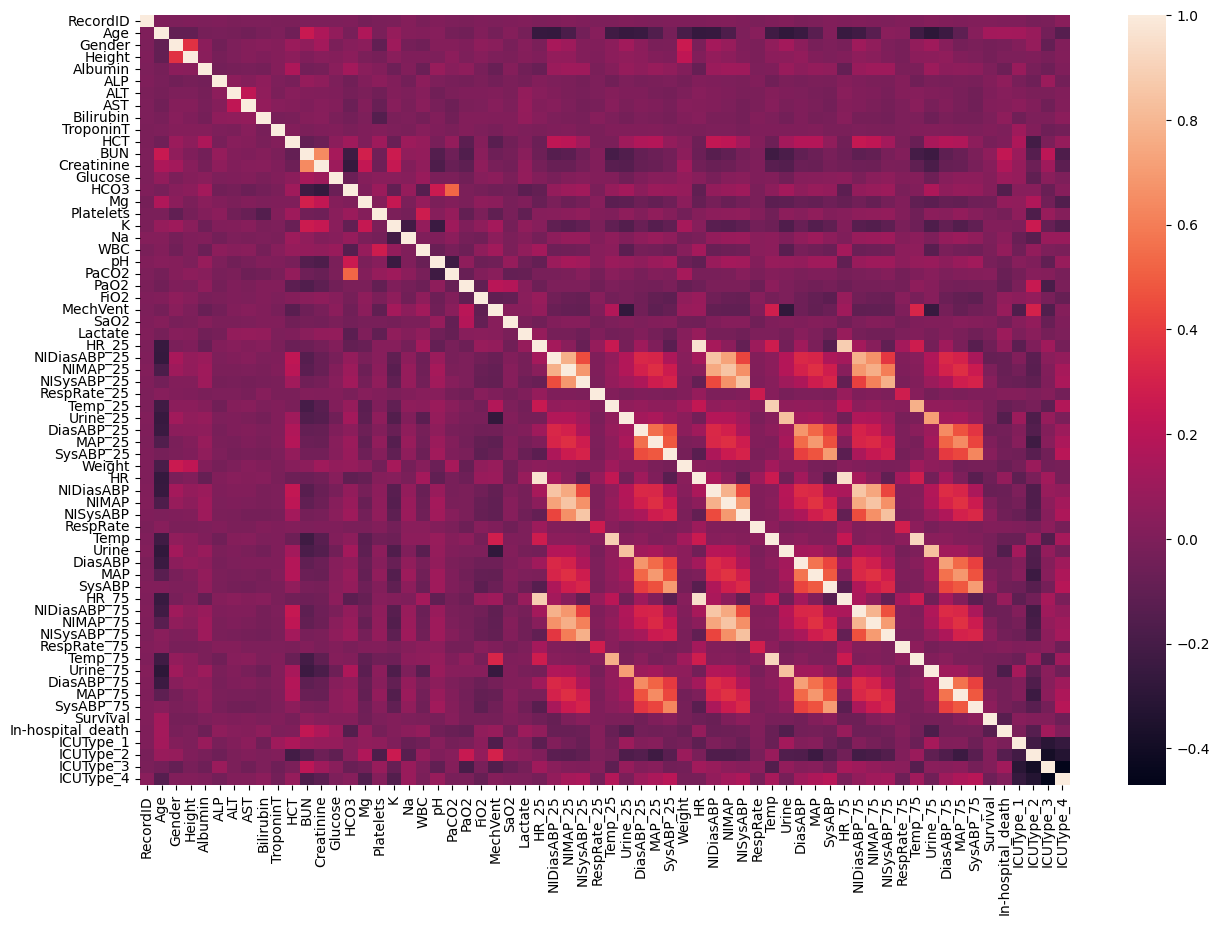

In [31]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(corr, ax=ax, xticklabels=True, yticklabels=True)

7683 7683


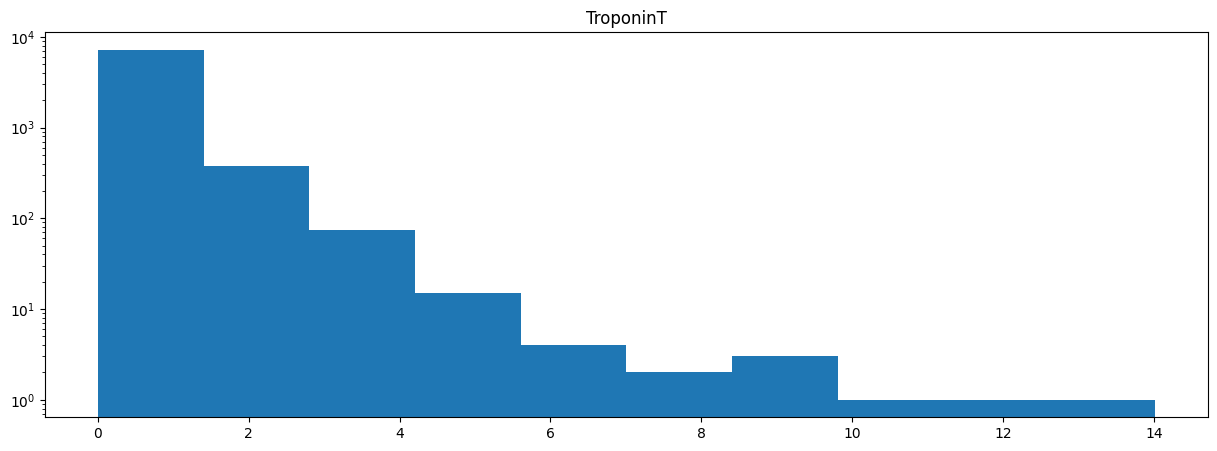

In [32]:
# Пример-проверка, что NaN удалились в столбце, где изначально было 77% NaN
data = df.to_numpy()
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(15, 5)
s = pd.Series(data[:, df.columns.get_loc("TroponinT")])
print(len(s), len(df.index))
axis.hist(s, bins = 10, log = True)
axis.set_title("TroponinT")
plt.show()

In [33]:
df.to_csv('dataset2.csv', index = False)

# 3.1. Отбор признаков

In [34]:
df = pd.read_csv('dataset2.csv')
df

,RecordID,Age,Gender,Height,Albumin,ALP,ALT,AST,Bilirubin,TroponinT,HCT,BUN,Creatinine,Glucose,HCO3,Mg,Platelets,K,Na,WBC,pH,PaCO2,PaO2,FiO2,MechVent,SaO2,Lactate,HR_25,NIDiasABP_25,NIMAP_25,NISysABP_25,RespRate_25,Temp_25,Urine_25,DiasABP_25,MAP_25,SysABP_25,Weight,HR,NIDiasABP,NIMAP,NISysABP,RespRate,Temp,Urine,DiasABP,MAP,SysABP,HR_75,NIDiasABP_75,NIMAP_75,NISysABP_75,RespRate_75,Temp_75,Urine_75,DiasABP_75,MAP_75,SysABP_75,Survival,In-hospital_death,ICUType_1,ICUType_2,ICUType_3,ICUType_4
0,132539.0,54.0,False,166.004972,2.999824,75.836610,27.400347,291.237037,5.739116,0.261842,32.500000,10.500000,0.750000,160.000000,27.000000,1.700000,203.000000,4.200000,136.500000,10.300000,7.365233,41.930065,100.638619,0.562844,False,100.385779,4.490527,63.00,43.250000,63.747500,104.00,15.000000,37.150,72.5000,44.821326,71.000273,73.655679,82.984193,73.0,49.000000,70.000000,110.0,18.000000,37.70,100.000000,46.549238,94.393848,105.642945,77.00,55.750000,77.170000,121.50,20.000000,37.900,217.50,73.024289,93.608061,130.256378,-1,0,False,False,False,True
1,132540.0,76.0,True,175.300000,4.323835,70.704609,9.803650,92.074943,0.086678,0.031235,28.655556,18.333333,1.100000,125.500000,22.333333,2.300000,178.600000,3.900000,137.000000,11.266667,7.395000,38.857143,210.142857,0.560000,True,96.833333,0.630535,80.00,51.000000,70.330000,104.00,18.015870,36.700,50.0000,55.000000,71.000000,104.500000,80.600000,80.0,59.000000,78.165000,115.0,17.846696,37.45,90.000000,59.000000,79.000000,116.500000,88.00,65.000000,85.250000,125.50,18.249919,37.600,220.00,62.000000,82.000000,125.000000,-1,0,False,True,False,False
2,132541.0,44.0,False,191.066165,2.500000,116.000000,83.000000,199.500000,2.900000,0.279851,28.460000,4.666667,0.333333,134.333333,25.000000,1.720000,89.666667,4.260000,138.333333,4.700000,7.495000,35.500000,134.500000,0.500000,True,95.000000,1.366667,75.50,73.250000,91.670000,127.00,28.270886,37.250,50.0000,62.250000,85.250000,120.500000,56.700000,85.5,79.000000,97.670000,134.0,19.504222,37.85,100.000000,67.000000,90.000000,125.000000,91.00,84.000000,103.000000,139.75,29.026320,38.175,170.00,73.500000,97.750000,135.250000,-1,0,False,False,True,False
3,132543.0,68.0,True,180.300000,4.400000,105.000000,12.000000,15.000000,0.200000,0.158444,37.442857,17.666667,0.766667,117.333333,27.666667,2.033333,330.000000,4.000000,139.333333,9.400000,7.450384,44.587909,151.841629,0.515453,False,95.711903,2.283417,63.75,61.250000,80.415000,116.00,13.500000,36.100,55.1423,62.418769,50.200187,99.940145,84.600000,74.0,64.000000,83.670000,120.0,16.000000,36.40,120.860943,79.549038,77.776137,125.048898,76.00,69.000000,86.670000,128.00,18.000000,36.400,668.75,59.412851,76.876189,149.011645,575,0,False,False,True,False
4,132545.0,88.0,False,171.506198,3.300000,215.507707,12.149334,71.285832,1.587533,0.594917,29.550000,35.000000,1.000000,102.500000,19.000000,1.550000,103.000000,4.320000,139.500000,4.300000,7.410338,41.684916,68.117953,0.477404,False,96.161964,1.207675,68.75,38.000000,70.000000,126.00,17.000000,36.650,40.0000,51.585388,67.901101,106.254022,99.190508,73.0,42.000000,75.330000,131.0,19.000000,37.00,50.000000,51.877871,74.230679,112.868457,81.25,54.000000,80.000000,142.00,21.000000,37.150,63.75,47.043351,97.871644,95.162443,918,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7678,152849.0,78.0,True,180.300000,3.575969,38.472489,16.696557,16.819556,0.386534,0.322133,29.275000,24.000000,1.000000,110.000000,21.666667,2.300000,118.250000,5.200000,133.500000,16.766667,7.375625,40.312500,159.250000,0.686364,True,96.875000,1.100000,98.00,52.000000,79.165000,133.50,16.571958,36.625,40.0000,58.000000,75.500000,111.000000,88.700000,103.0,56.000000,83.330000,143.0,15.477031,36.85,80.000000,62.000000,83.000000,130.000000,105.50,62.500000,

Используем функцию SelectKBest для нахождения k = 20 признаков (треть от имеющихся), имеющих наибольшее влияние на 2 выходные переменные, со следующими критериями:
1) Критерий хи-квадрат для классификации (метка 'In-hospital_death')
2) Коэффициент линейной корреляции Пирсона для регрессии (метка 'Survival')

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

In [ ]:
Y_cls = df['In-hospital_death']
X_cls = df.drop(columns = ['In-hospital_death', 'Survival'])
Y_reg = df['Survival']
X_reg = df.drop(columns = ['In-hospital_death', 'Survival'])

    # может лучше ничего не убирать??
# 20 признаков для классификации
selector_cls = SelectKBest(chi2, k = 20)
X_new = selector_cls.fit_transform(X_cls*1, Y_cls)
features_cls = X_cls.columns[selector_cls.get_support()]
print(features_cls)

# 20 признаков для регрессии
selector_reg = SelectKBest(f_regression, k = 20)
X_new = selector_reg.fit_transform(X_reg*1, Y_reg)
features_reg = X_reg.columns[selector_reg.get_support()]
print(features_reg)

In [ ]:
# Красным показаны значения p-values для 20 признаков, которые мы выбрали
# Синим выделены признаки, которые мы не выбираем

mask = selector_cls.get_support()
scores = -np.log10(selector_cls.pvalues_)
X_indices = np.arange(X_cls.shape[-1])
plt.figure(1, figsize=[15, 7])
plt.clf()
plt.bar(X_indices[mask], scores[mask] ** 0.5, width=0.2, color = 'red')
plt.bar(X_indices[~mask], scores[~mask] ** 0.5, width=0.2, color = 'blue')
plt.show()
X_cls = X_cls.loc[:, mask]

In [ ]:
mask = selector_reg.get_support()
scores = -np.log10(selector_reg.pvalues_)
X_indices = np.arange(X_reg.shape[-1])
plt.figure(1, figsize=[15, 7])
plt.clf()
plt.bar(X_indices[mask], scores[mask] ** 0.5, width=0.2, color = 'red')
plt.bar(X_indices[~mask], scores[~mask] ** 0.5, width=0.2, color = 'blue')
plt.show()
X_reg = X_reg.loc[:, mask]

# 3.2 Подбор и реализация алгоритмов выявления зависимостей параметров данных

Первый алгортим выяснения зависимостей. PCA-анализ (Метод главных компонент)
Определяем 2 компоненты в признаковом пространстве, для которых дисперсия значений будет наибольшей.
С помощью цвета можно определить разброс признака внутри компонент и таким образом отследить зависимость одного признака от остальных.
Показан график для признака 'Age' для регресионного анализа. Внизу представлены сформированные компоненты.

In [ ]:
from sklearn import decomposition

X = X_reg.to_numpy()
X = X.astype(float)
pca = decomposition.PCA(n_components=2)
X_centered = X
X_centered = (X - X.mean(axis=0)) / np.std(X, axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
# p - признак, по которому выводим цвет, синий - ближе к минимальному значению, красный - к максимальному
p = 0
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(10, 10)
axis.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=(X[:, p] - np.min(X[:, p])) /  (np.max(X[:, p])- np.min(X[:, p])), cmap='jet')
plt.show()

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name) for value, name in zip(component, X_reg.columns)))

In [ ]:
p = 0
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(10, 10)
temp = Y_reg.copy()
temp[temp == -1] = float("+inf")
temp[temp < 2] = 2
temp = 1 / np.log2(temp)
indx = temp > 0.3
axis.scatter(X_pca[indx, 0], X_pca[indx, 1], s = X[indx, p], c = temp[indx], cmap='copper')
plt.show()

In [ ]:
X = X_cls.to_numpy()
X = X.astype(float)
pca = decomposition.PCA(n_components=2)
X_centered = X
X_centered = (X - X.mean(axis=0)) / np.std(X, axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
# p - признак, по которому выводим цвет, синий - ближе к минимальному значению, красный - к максимальному
p = 0
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(10, 10)
axis.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=(X[:, p] - np.min(X[:, p])) /  (np.max(X[:, p])- np.min(X[:, p])), cmap='jet')
plt.show()

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name) for value, name in zip(component, X_cls.columns)))

In [ ]:
p = 0
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(10, 10)
axis.scatter(X_pca[:, 0], X_pca[:, 1], s = 10 + 50*Y_cls, c =(X[:, p] - np.min(X[:, p])) /  (np.max(X[:, p])- np.min(X[:, p])), cmap='jet')
plt.show()

In [ ]:
X_reg_corr = X_reg.corr()
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(X_reg_corr, ax=ax, xticklabels=True, yticklabels=True)

In [ ]:
X_cls_corr = X_cls.corr()
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.heatmap(X_cls_corr, ax=ax, xticklabels=True, yticklabels=True)

# 3.3 Разбиение обработанных данных на обучающую, валидационную и тестирующую выборки

In [ ]:
print([sum(Y_cls), len(Y_cls)])

Дисбаланс для задачи классификации составляет 1090/7683 = 14%. Это означает, что 14% данных относятся к классу "Умерли в госпитализации", а оставшиеся к классу "Не умерли в госпитализации". По описанию несбалансированных данных Google (https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) незначительный уровень дисбаланса соответствует доле меньшинства в 20-40% от всего множества данных. Поэтому предлагается удалить некоторое число данных, относящихся к мажоритарному классу, чтобы дисбаланс стал равен 20%.

In [ ]:
print([sum(Y_reg==-1), sum(Y_reg==0), sum(Y_reg==1), sum((Y_reg>=0)*(Y_reg<=360)), sum(Y_reg>360), max(Y_reg), Y_reg.quantile(0.95), len(Y_reg)])

In [ ]:
plt.plot(Y_reg.sort_values().values)

Непоследовательность определения значений для решения задачи регрессии состоит в том, что 4794/7683 = 62% людей имеют поле 'Survival' равным -1, то есть не умерли на момент получения данных, по сути это означает, что эта -1 соответствует +Inf. Преобразовываем поле 'Survival' по следующей формуле, для получения значений, которые можно предсказать.

In [ ]:
temp = Y_reg.copy()
temp[temp == -1] = float("+inf")
temp[temp < 2] = 2
temp = 1 / np.log2(temp)
Y_reg = temp
plt.plot(Y_reg.sort_values().values)

In [ ]:
from sklearn.model_selection import train_test_split

indx_1 = Y_cls == 1
indx_0 = Y_cls == 0
# Удаляем строчки с мажоритарным классом с вероятностью (1 - sum(Y_cls) / len(Y_cls))
counter = 0
for i in range(len(Y_cls)):
    if indx_0[i] == True:
        counter = counter + 1
    if counter > 2741:
        indx_0[i] = False

X_train_cls1, X_test_cls1, y_train_cls1, y_test_cls1 = train_test_split(X_cls[indx_1], Y_cls[indx_1], test_size=0.1, random_state=1)
X_train_cls1, X_val_cls1, y_train_cls1, y_val_cls1 = train_test_split(X_train_cls1, y_train_cls1, test_size=0.2, random_state=1)

X_train_cls0, X_test_cls0, y_train_cls0, y_test_cls0 = train_test_split(X_cls[indx_0], Y_cls[indx_0], test_size=0.24, random_state=1)
X_train_cls0, X_val_cls0, y_train_cls0, y_val_cls0 = train_test_split(X_train_cls0, y_train_cls0, test_size=0.63, random_state=1)

X_train_cls = pd.concat([X_train_cls0, X_train_cls1])
y_train_cls = pd.concat([y_train_cls0, y_train_cls1])
X_val_cls = pd.concat([X_val_cls0, X_val_cls1])
y_val_cls = pd.concat([y_val_cls0, y_val_cls1])
X_test_cls = pd.concat([X_test_cls0, X_test_cls1])
y_test_cls = pd.concat([y_test_cls0, y_test_cls1])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, Y_reg, test_size=0.1, random_state=1) # 0.2 тестовая выборка
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.2, random_state=1) # 0.2*0.8 = 0.18 валидационная, 0.72 обучающая


# 3.6 Выбор модели прогнозирования и настройка гиперпараметров для классификации

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn import metrics

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train_cls, y_train_cls)
    pred_cls = clf.predict(X_val_cls)
    score = f1_score(y_val_cls, pred_cls)
    print(name, score)

Для определения лучших алгоритмов бинарной классификации было проведено машинное обучение с использованием основных интеллектуальных моделей на основании 1526 тренировочных данных (783 "0" и 783 "1", пропорция 1:1 так как данные несбалансированны). Критерий качества (Accuracy) высчитывался на основании 1536 валидационных значений (1318 "0" и 218 "1" - пропорция как в данных в целом).
Пороговое значение для точности равно: (1318/1536)*(1318/1536)+(218/1536)*(218/1536) ~ 0,76. Оно аналогично случайному выбору.

Лучшие модели по критерию f1-score: Decision Tree, Random Forest, AdaBoost (аналогичен Random Forest), Linear SVM, Naive Bayes
SVM убираем из-за большой вычислительной сложности O(n^2*p+n^3) (n - размер тренировочного набора, p - количество признаков)
Random Forest/Decision Tree оставляем, его сложность O(n^2*p)
Naive Bayes оставляем, его сложность O(n*p)
Neural Net предлагается добавить, её сложность линейно зависит от n.

In [ ]:
parameters = {'max_depth':[9, 11, 13], 'n_estimators':[100, 200, 300], 'max_features': ['sqrt', 'log2']}

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, scoring='f1')
clf.fit(X_train_cls, y_train_cls)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_cls = clf.predict(X_val_cls)

print(precision_score(y_val_cls, pred_cls))
print(recall_score(y_val_cls, pred_cls))
print(accuracy_score(y_val_cls, pred_cls))
print(f1_score(y_val_cls, pred_cls))
print(balanced_accuracy_score(y_val_cls, pred_cls))

In [ ]:
pred_cls = clf.predict_proba(X_val_cls)
fpr, tpr, _ = metrics.roc_curve(y_val_cls,  pred_cls[:, 1])
auc = metrics.roc_auc_score(y_val_cls, pred_cls[:, 1])

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Random Forest при настройке гиперпараметров улучшил показатель f1_score с 0.484 (max_depth=5, n_estimators=10, max_features=1) до 0.559 (max_depth=11, n_estimators=100, max_features='sqrt').

In [ ]:
parameters = {'hidden_layer_sizes':[(20,), (40,), (100,)], 'activation':['identity', 'relu']}

clf = GridSearchCV(estimator=MLPClassifier(), param_grid=parameters, scoring='f1')
clf.fit(X_train_cls, y_train_cls)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_cls = clf.predict(X_val_cls)

print(precision_score(y_val_cls, pred_cls))
print(recall_score(y_val_cls, pred_cls))
print(accuracy_score(y_val_cls, pred_cls))
print(f1_score(y_val_cls, pred_cls))
print(balanced_accuracy_score(y_val_cls, pred_cls))

In [ ]:
pred_cls = clf.predict_proba(X_val_cls)
fpr, tpr, _ = metrics.roc_curve(y_val_cls,  pred_cls[:, 1])
auc = metrics.roc_auc_score(y_val_cls, pred_cls[:, 1])

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
parameters = {'var_smoothing':[1e-9, 1e-7, 1e-6, 1e-5]}

clf = GridSearchCV(estimator=GaussianNB(), param_grid=parameters, scoring='f1')
clf.fit(X_train_cls, y_train_cls)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_cls = clf.predict(X_val_cls)

print(precision_score(y_val_cls, pred_cls))
print(recall_score(y_val_cls, pred_cls))
print(accuracy_score(y_val_cls, pred_cls))
print(f1_score(y_val_cls, pred_cls))
print(balanced_accuracy_score(y_val_cls, pred_cls))

In [ ]:
pred_cls = clf.predict_proba(X_val_cls)
fpr, tpr, _ = metrics.roc_curve(y_val_cls,  pred_cls[:, 1])
auc = metrics.roc_auc_score(y_val_cls, pred_cls[:, 1])

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# 3.7 Прогноз значения целевой переменной, качество модели для классификации

In [ ]:
clf = RandomForestClassifier(max_depth=9, n_estimators=300, max_features='log2')
clf.fit(X_train_cls, y_train_cls)
pred_cls = clf.predict(X_test_cls)

print(precision_score(y_test_cls, pred_cls))
print(recall_score(y_test_cls, pred_cls))
print(accuracy_score(y_test_cls, pred_cls))
print(f1_score(y_test_cls, pred_cls))
print(balanced_accuracy_score(y_test_cls, pred_cls))

In [ ]:
pred_cls = clf.predict_proba(X_val_cls)
fpr, tpr, _ = metrics.roc_curve(y_val_cls,  pred_cls[:, 1])
auc = metrics.roc_auc_score(y_val_cls, pred_cls[:, 1])

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# 3.4. Выбор модели прогнозирования и настройка гиперпараметров для регрессии

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn import metrics

names = [
    "LinearRegression",
    "Ridge",
    "BayesianRidge",
    "PolynomialFeatures",
    "SVR linear",
    "SVR rbf",
    "KNeighborsRegressor",
    "GaussianProcessRegressor",
    "DecisionTreeRegressor",
    "RandomForestRegressor",
    "MLPRegressor",
]

regressors = [
    LinearRegression(),
    Ridge(alpha=1.0, solver='auto'),
    BayesianRidge(),
    Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))]),
    SVR(kernel='linear'),
    SVR(kernel='rbf'),
    KNeighborsRegressor(3),
    GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel()),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=2),
    MLPRegressor(alpha=1, max_iter=1000),
]

for name, rgr in zip(names, regressors):
    rgr.fit(X_train_reg, y_train_reg)
    pred_reg = rgr.predict(X_val_reg)
    score = mean_squared_error(y_val_reg, pred_reg)
    print(name, score)

In [ ]:
# Пороговое значение MSE, когда в качестве y выбираем среднее значение по y
np.mean((np.mean(y_val_reg)-y_val_reg) **2)

Выбираем следующие модели для подбора гиперпараметров:
LinearRegression (без настройки)
BayesianRidge 
KNeighborsRegressor 
DecisionTreeRegressor
RandomForestRegressor 
MLPRegressor

In [ ]:
parameters = {'max_depth':[13], 'n_estimators':[200], 'max_features': ['sqrt']}

rgr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters, scoring='neg_mean_squared_error')
rgr.fit(X_train_reg, y_train_reg)

results = pd.DataFrame.from_dict(rgr.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_reg = rgr.predict(X_val_reg)

print(mean_squared_error(y_val_reg, pred_reg))
print(r2_score(y_val_reg, pred_reg))
print(mean_absolute_error(y_val_reg, pred_reg))
print(max_error(y_val_reg, pred_reg))

In [ ]:
parameters = {'max_depth':[5, 10, 15], 'max_features': [1, 2, 'log2', 'sqrt']}

rgr = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=parameters, scoring='neg_mean_squared_error')
rgr.fit(X_train_reg, y_train_reg)

results = pd.DataFrame.from_dict(rgr.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_reg = rgr.predict(X_val_reg)

print(mean_squared_error(y_val_reg, pred_reg))
print(r2_score(y_val_reg, pred_reg))
print(mean_absolute_error(y_val_reg, pred_reg))
print(max_error(y_val_reg, pred_reg))

In [ ]:
parameters = {'n_neighbors':[15, 25, 50], 'weights':['uniform', 'distance'], 'p':[1, 2]}

rgr = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=parameters, scoring='neg_mean_squared_error')
rgr.fit(X_train_reg, y_train_reg)

results = pd.DataFrame.from_dict(rgr.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_reg = rgr.predict(X_val_reg)

print(mean_squared_error(y_val_reg, pred_reg))
print(r2_score(y_val_reg, pred_reg))
print(mean_absolute_error(y_val_reg, pred_reg))
print(max_error(y_val_reg, pred_reg))

In [ ]:
parameters = {'n_iter':[500], 'tol':[1e-4], 'alpha_1':[1e-5, 1e-6, 1e-7], 'alpha_2':[1e-5, 1e-6, 1e-7]}

rgr = GridSearchCV(estimator=BayesianRidge(), param_grid=parameters, scoring='neg_mean_squared_error')
rgr.fit(X_train_reg, y_train_reg)

results = pd.DataFrame.from_dict(rgr.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_reg = rgr.predict(X_val_reg)

print(mean_squared_error(y_val_reg, pred_reg))
print(r2_score(y_val_reg, pred_reg))
print(mean_absolute_error(y_val_reg, pred_reg))
print(max_error(y_val_reg, pred_reg))

In [ ]:
parameters = {'hidden_layer_sizes':[(20, ), (50, ), (100, )], 'activation':['relu', 'logistic'], 'solver':['adam', 'lbfgs']}

rgr = GridSearchCV(estimator=MLPRegressor(), param_grid=parameters, scoring='neg_mean_squared_error')
rgr.fit(X_train_reg, y_train_reg)

results = pd.DataFrame.from_dict(rgr.cv_results_)
results = results.sort_values('rank_test_score', ignore_index=True)
print(results['params'][0])
pred_reg = rgr.predict(X_val_reg)

print(mean_squared_error(y_val_reg, pred_reg))
print(r2_score(y_val_reg, pred_reg))
print(mean_absolute_error(y_val_reg, pred_reg))
print(max_error(y_val_reg, pred_reg))